# Introducción

El objetivo del proyecto es predecir la mediana de los precios de todos los tokens  al contrato [Fluf World](https://opensea.io/collection/fluf?search[sortAscending]=true&search[sortBy]=PRICE).

Como todo proyecto de Inteligencia Artificial y Machine Learning, primero se piensan los datos.


A través de este notebook se hace una  (o゜▽゜)o☆ **guía interactiva** de los procesos que se llevaron a cabo  de inicio a fin para solucionar el problema, los scripts que se utilizaron en el proceso de entrenamiento final se encuentran [GitHub](https://github.com/F4B123/IA-final) donde hay dos ejemplos de los entrenamientos de las redes neuronales.

##  1. Obtener la información  

Para iniciar el proceso de entrenamiento de la red neuronal, debemos obtener todas las transacciones del contrato inteligente (más información en el documento. Es decir, todas las transacciones de los tokens, en este caso solo estamos interesados en dos tipos de transacción: compra y subasta. 

Existen muchas maneras de obtener esta información, en este caso utilizamos Etherscan, una web dedicada a extraer información de la blockchain de Ethereum y darle formato para que sea de fácil lectura. 

Al contrato [Fluf World](https://opensea.io/collection/fluf?search[sortAscending]=true&search[sortBy]=PRICE) podemos con la ayuda de Etherscan ver [todas las transacciones de este contrato](https://etherscan.io/nfttracker?contractAddress=0xCcc441ac31f02cD96C153DB6fd5Fe0a2F4e6A68d), para descargar esas transacciones podemos usar la API oficial de Etherscan o podemos descargar estos usando la función de [descarga de csv](https://etherscan.io/exportData?type=nfttracker-trade&q=0xCcc441ac31f02cD96C153DB6fd5Fe0a2F4e6A68d).


## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. Si no ha instalado los requerimientos debe descomentar la siguiente linea de código y ejecutarla. 

In [1]:
#!pip install -r requirements.txt

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

Ejemplo del formato de las transacciones, el archivo con todas las transacciones se encuentra en [Github](https://github.com/F4B123/IA-final/blob/main/src/data/fluffNftTracker.csv), si se quiere probar con otro archivo basta con cambiar la ruta del archivo

In [3]:
df = pd.read_csv("Datos_finales/Datos_antes_pandemia/data_antes_vol.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros
0    2010-01-01      0.000000
1    2010-01-02      4.256365
2    2010-01-03      0.794545
3    2010-01-04      0.787899
4    2010-01-05      0.601027
...         ...           ...
3648 2019-12-27      4.003614
3649 2019-12-28      2.090121
3650 2019-12-29      0.539108
3651 2019-12-30      1.815513
3652 2019-12-31      1.871355

[3653 rows x 2 columns]

---

## Modelo

Se construirá un modelo de redes neuronales LSTM que toma encuenta los datos del promedio, mediana, desviación,mediana suavizada y el retorno para predecir la mediana suavizada tomando un ventaneo de 5 dias,es decir se toman los registros de 5 días seguidos para predecir la mediana suavizada del siguiente.

Antes de construir el modelo, hay que estructurar nuestros datos:

### Normalización

teniendo encuenta que se usará una red neuronal LSTM, esta es sensible a la escala de los datos; es por eso que normalizamos nuestros datos a un rango [0,1] mediante el método Min-Max el cual consiste en lo siguiente:

$$x_{scalado}=\frac{x-x_\min}{x_\max-x_\min}$$

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

Se realiza una partición de los datos, de tal manera que el 80% de los primeros registros sean para entrenamiento y el restante sea para probar el modelo. 

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

ahora hay que redimensionar nuestros datos para que nos quede con ventaneo de 5 dias, para el caso de entrenamiento al modelo se le pasan 371 datos , el primero de estos datos corresponde a un arreglo con el registro de los 5 primeros días, el segundo dato corresponde a un arreglo con los registros desde el día 2 hasta el día 6, y así sucesivamente, donde el último dato corresponde a un arreglo con los registros desde el día 371 hasta el día 376.


los datos de referencia y_train, se redimensionan de tal manera que nos quede el registro de la mediana suavizada apartir del día 6. 

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [55]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag,fecha):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1892 - mae: 0.7774 - val_loss: 0.8113 - val_mae: 0.7030
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1576 - mae: 0.7705 - val_loss: 0.8082 - val_mae: 0.7027
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1444 - mae: 0.7702 - val_loss: 0.8053 - val_mae: 0.7018
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1362 - mae: 0.7681 - val_loss: 0.8025 - val_mae: 0.7011
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1306 - mae: 0.7648 - val_loss: 0.8011 - val_mae: 0.7013
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1266 - mae: 0.7666 - val_loss: 0.7992 - val_mae: 0.7010
Epoch 7/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1236 - mae: 0.7652 - val_loss: 0.7966 - val_mae: 0.6998
Epoch 8/100
128/128 [==

Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1007 - mae: 0.7587 - val_loss: 0.7634 - val_mae: 0.6859
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1007 - mae: 0.7613 - val_loss: 0.7614 - val_mae: 0.6841
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1008 - mae: 0.7605 - val_loss: 0.7590 - val_mae: 0.6812
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1003 - mae: 0.7582 - val_loss: 0.7615 - val_mae: 0.6841
Epoch 66/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1004 - mae: 0.7599 - val_loss: 0.7623 - val_mae: 0.6852
Epoch 67/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1001 - mae: 0.7621 - val_loss: 0.7611 - val_mae: 0.6835
Epoch 68/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1001 - mae: 0.7590 - val_loss: 0.7600 - val_mae: 0.6830
Epoch 69/100
128/128 [==============================] - 1s 5ms

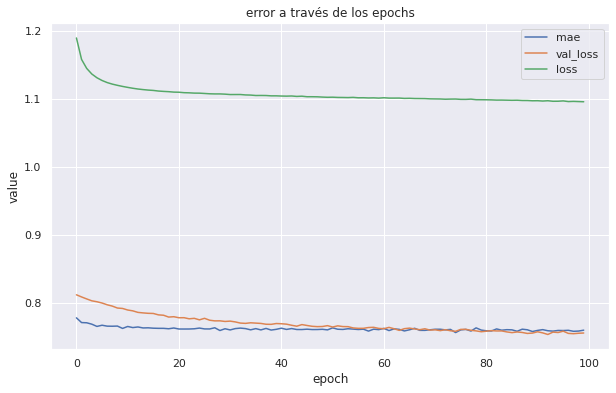

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.3312104182511069
MAE is : 0.8465026002271236
RMSE is : 1.1537809229880285
MAPE is : 42.19963975464001
Evaluation metric results:
MSE is : 0.9580039747060147
MAE is : 0.7553969141847464
RMSE is : 0.9787767747070906
MAPE is : 41.82870525611565
(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 9ms/step - loss: 1.1457 - mae: 0.7648 - val_loss: 0.7972 - val_mae: 0.6978
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1298 - mae: 0.7651 - val_loss: 0.7963 - val_mae: 0.6999
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1237 - mae: 0.7666 - val_loss: 0.7913 - val_mae: 0.6968
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1193 - mae: 0.7642 - val_loss: 0.7875 - val_mae: 0.6948
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1163 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0949 - mae: 0.7579 - val_loss: 0.7504 - val_mae: 0.6779
Epoch 60/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0945 - mae: 0.7573 - val_loss: 0.7490 - val_mae: 0.6768
Epoch 61/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0950 - mae: 0.7589 - val_loss: 0.7485 - val_mae: 0.6760
Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0945 - mae: 0.7559 - val_loss: 0.7505 - val_mae: 0.6782
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0944 - mae: 0.7582 - val_loss: 0.7486 - val_mae: 0.6766
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0942 - mae: 0.7574 - val_loss: 0.7467 - val_mae: 0.6741
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0938 - mae: 0.7551 - val_loss: 0.7488 - val_mae: 0.6766
Epoch 66/100
128/128 [==============================] - 1s 5ms

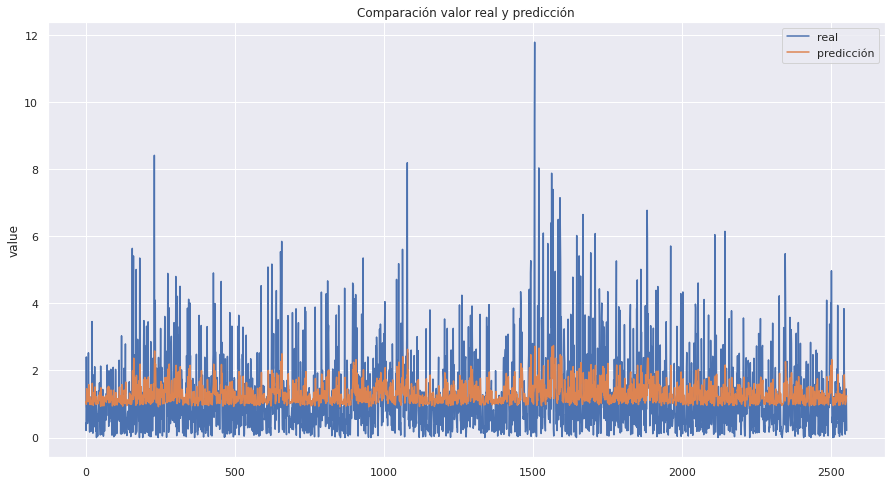

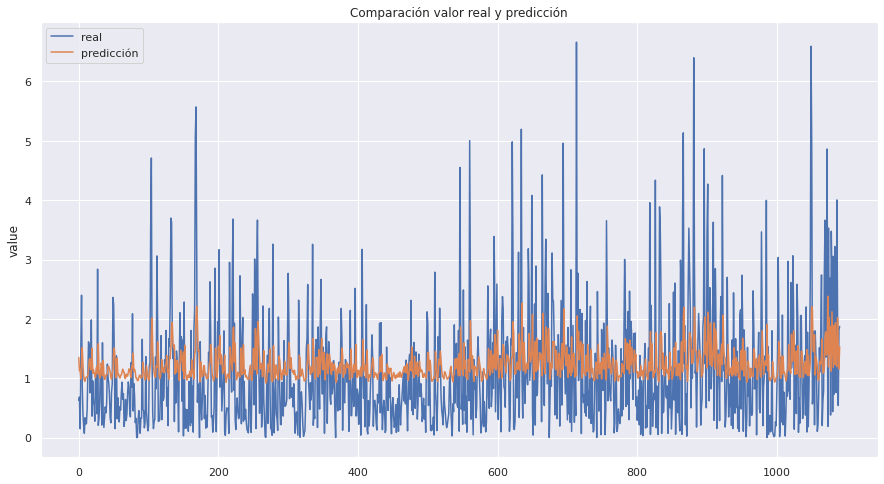

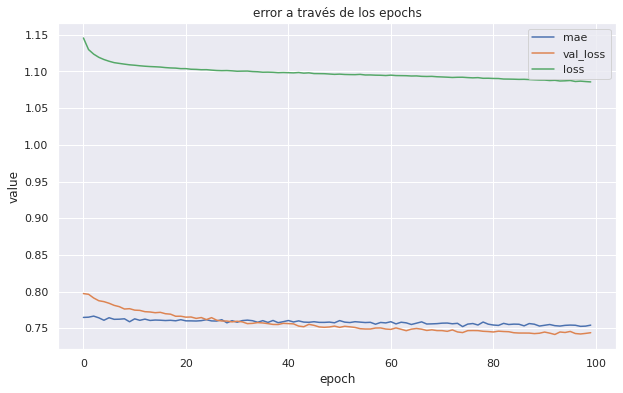

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.3179736174306314
MAE is : 0.8396001861371363
RMSE is : 1.148030320780175
MAPE is : 41.7598122139701
Evaluation metric results:
MSE is : 0.9530253049027622
MAE is : 0.7523287472295154
RMSE is : 0.9762301495563237
MAPE is : 41.62616719434656
(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1161 - mae: 0.7599 - val_loss: 0.7831 - val_mae: 0.6936
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1131 - mae: 0.7628 - val_loss: 0.7826 - val_mae: 0.6953
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1106 - mae: 0.7645 - val_loss: 0.7774 - val_mae: 0.6907
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1094 - mae: 0.7620 - val_loss: 0.7767 - val_mae: 0.6903
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1087 - mae: 0.

Epoch 59/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0938 - mae: 0.7578 - val_loss: 0.7501 - val_mae: 0.6776
Epoch 60/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0934 - mae: 0.7570 - val_loss: 0.7484 - val_mae: 0.6764
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0940 - mae: 0.7588 - val_loss: 0.7476 - val_mae: 0.6755
Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0935 - mae: 0.7553 - val_loss: 0.7505 - val_mae: 0.6781
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0933 - mae: 0.7580 - val_loss: 0.7484 - val_mae: 0.6764
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0932 - mae: 0.7571 - val_loss: 0.7461 - val_mae: 0.6738
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0928 - mae: 0.7547 - val_loss: 0.7487 - val_mae: 0.6766
Epoch 66/100
128/128 [==============================] - 1s 5ms

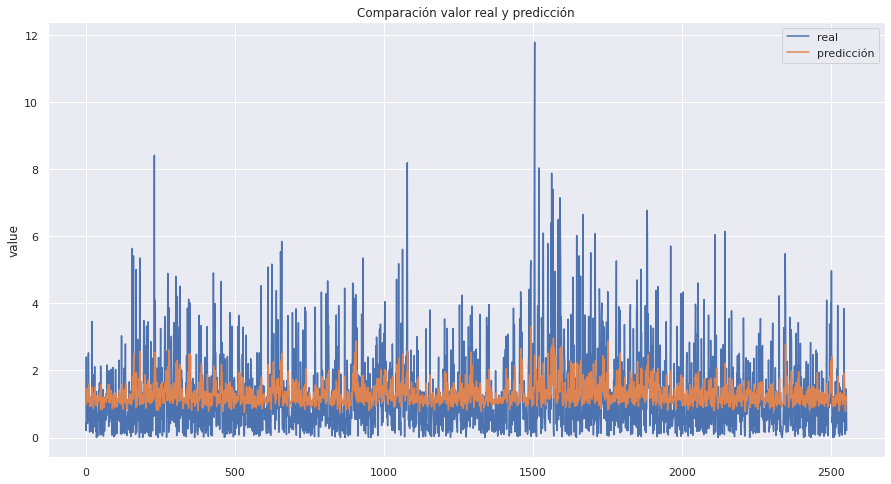

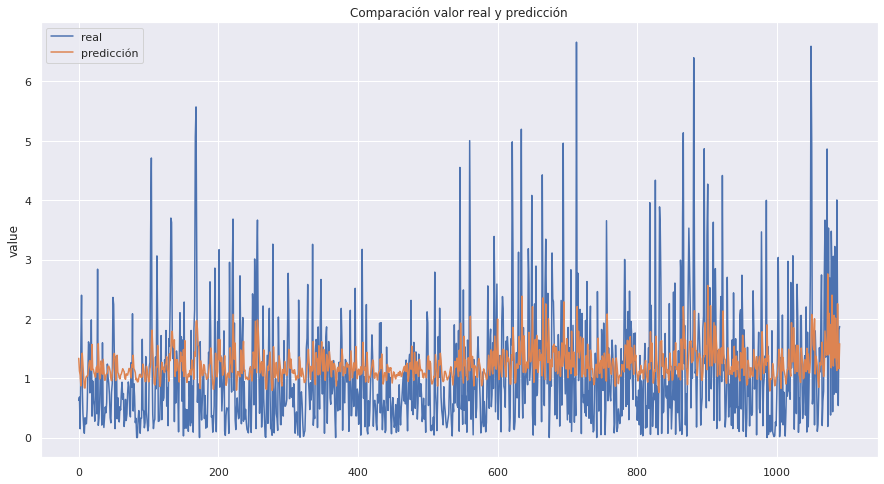

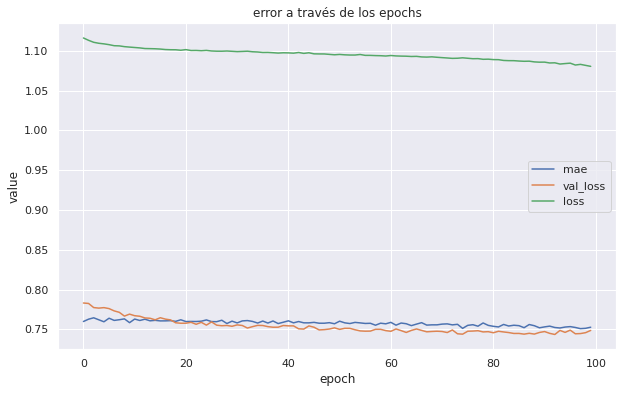

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.3132478229819216
MAE is : 0.8383326624558768
RMSE is : 1.1459702539690642
MAPE is : 41.67373998928761
Evaluation metric results:
MSE is : 0.948201591293702
MAE is : 0.7484903679972315
RMSE is : 0.9737564332489423
MAPE is : 41.30343493956154
(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.1290 - mae: 0.7654 - val_loss: 0.7910 - val_mae: 0.6984
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1190 - mae: 0.7657 - val_loss: 0.7854 - val_mae: 0.6966
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1138 - mae: 0.7654 - val_loss: 0.7767 - val_mae: 0.6899
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1110 - mae: 0.7626 - val_loss: 0.7778 - val_mae: 0.6904
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1097 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0911 - mae: 0.7562 - val_loss: 0.7506 - val_mae: 0.6779
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0903 - mae: 0.7553 - val_loss: 0.7502 - val_mae: 0.6771
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0908 - mae: 0.7570 - val_loss: 0.7475 - val_mae: 0.6757
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0904 - mae: 0.7536 - val_loss: 0.7523 - val_mae: 0.6788
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0898 - mae: 0.7562 - val_loss: 0.7507 - val_mae: 0.6771
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0892 - mae: 0.7554 - val_loss: 0.7469 - val_mae: 0.6740
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0886 - mae: 0.7526 - val_loss: 0.7498 - val_mae: 0.6774
Epoch 66/100
128/128 [==============================] - 1s 7ms

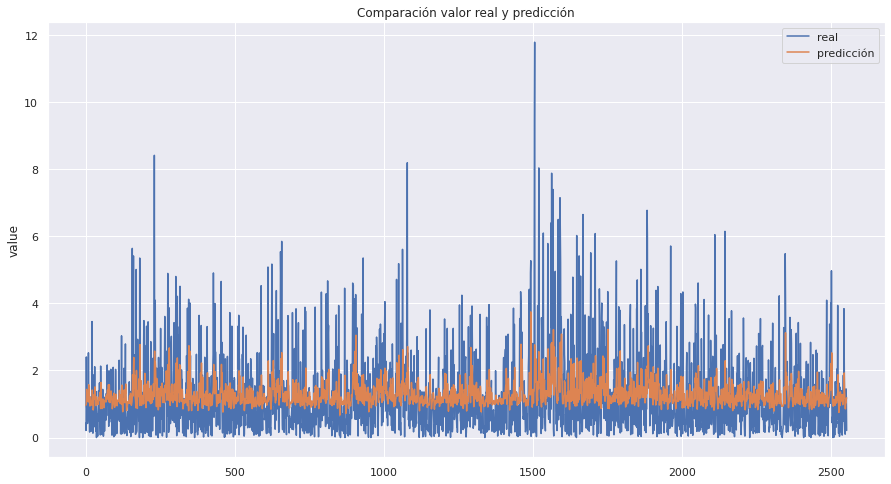

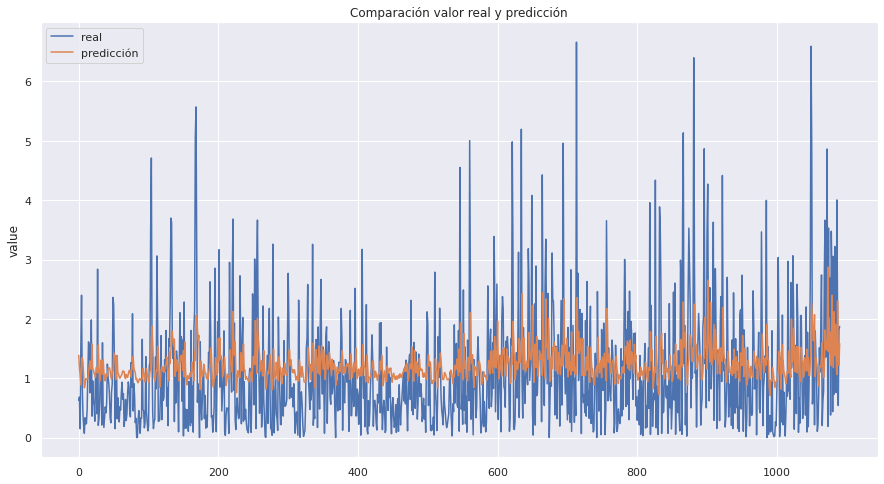

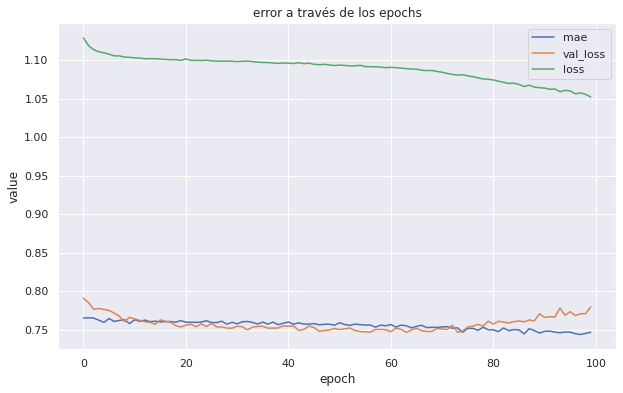

35/35 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2924481455606165
MAE is : 0.8300202067817468
RMSE is : 1.1368588943051008
MAPE is : 41.04813039231597
Evaluation metric results:
MSE is : 0.956536820648801
MAE is : 0.7457878319535145
RMSE is : 0.9780270040488662
MAPE is : 40.79071725786622
(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 14ms/step - loss: 1.1314 - mae: 0.7670 - val_loss: 0.7900 - val_mae: 0.6983
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1184 - mae: 0.7656 - val_loss: 0.7807 - val_mae: 0.6945
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1120 - mae: 0.7646 - val_loss: 0.7711 - val_mae: 0.6871
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1086 - mae: 0.7622 - val_loss: 0.7727 - val_mae: 0.6876
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1076 - m

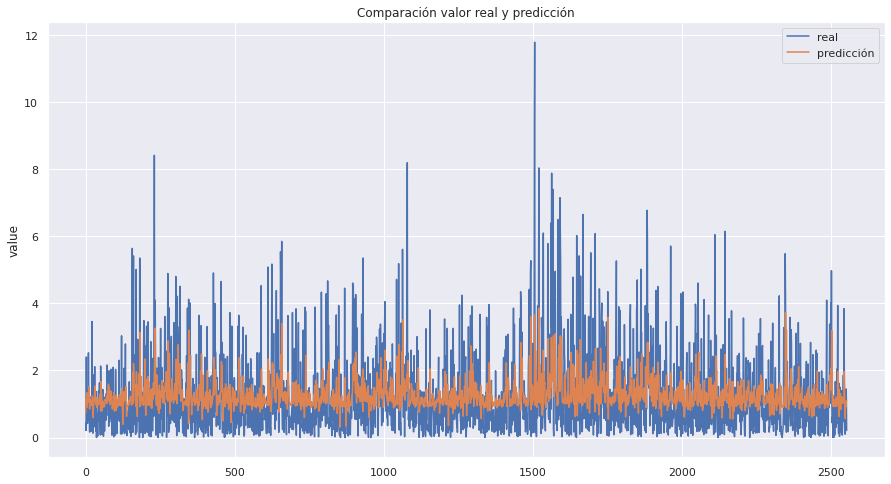

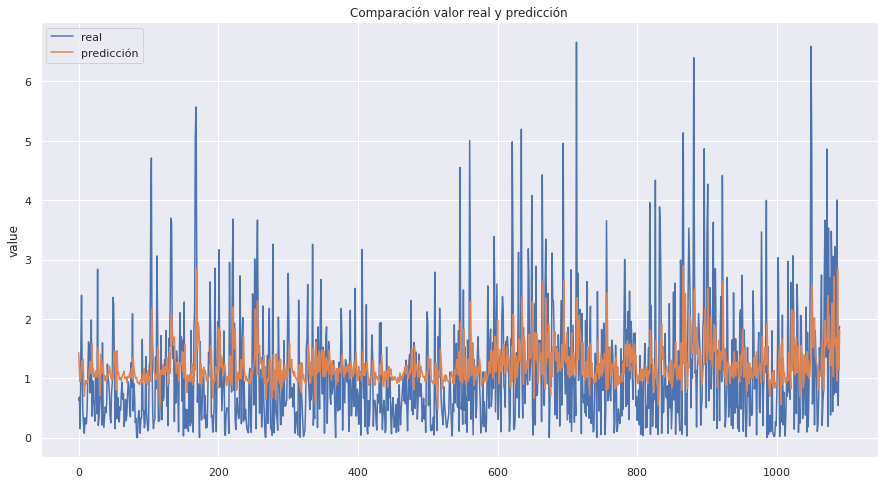

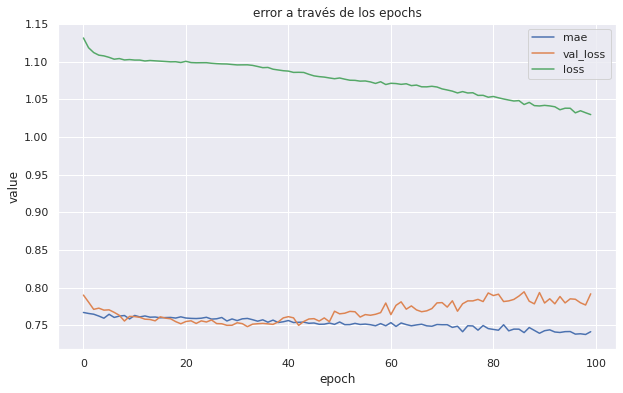

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.2697221770263931
MAE is : 0.8231762708261261
RMSE is : 1.1268194962044245
MAPE is : 40.53154504668389
Evaluation metric results:
MSE is : 0.9792205678413471
MAE is : 0.7453581905230089
RMSE is : 0.9895557426650341
MAPE is : 40.471148616305385
(2552, 5, 1) (2552, 1)
(1091, 5, 1) (1091, 1)
Epoch 1/100
128/128 [==============================] - 6s 25ms/step - loss: 1.1299 - mae: 0.7667 - val_loss: 0.7840 - val_mae: 0.6954
Epoch 2/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1145 - mae: 0.7644 - val_loss: 0.7723 - val_mae: 0.6903
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1082 - mae: 0.7635 - val_loss: 0.7636 - val_mae: 0.6834
Epoch 4/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1052 - mae: 0.7615 - val_loss: 0.7665 - val_mae: 0.6843
Epoch 5/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1059 -

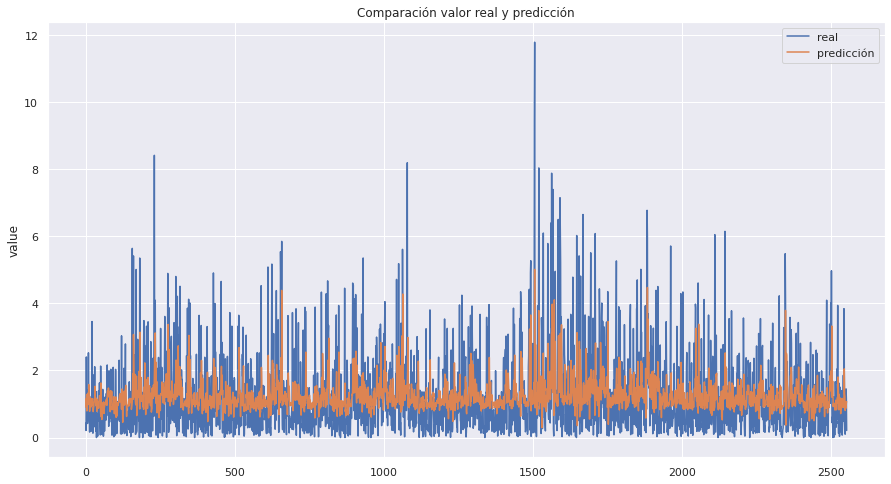

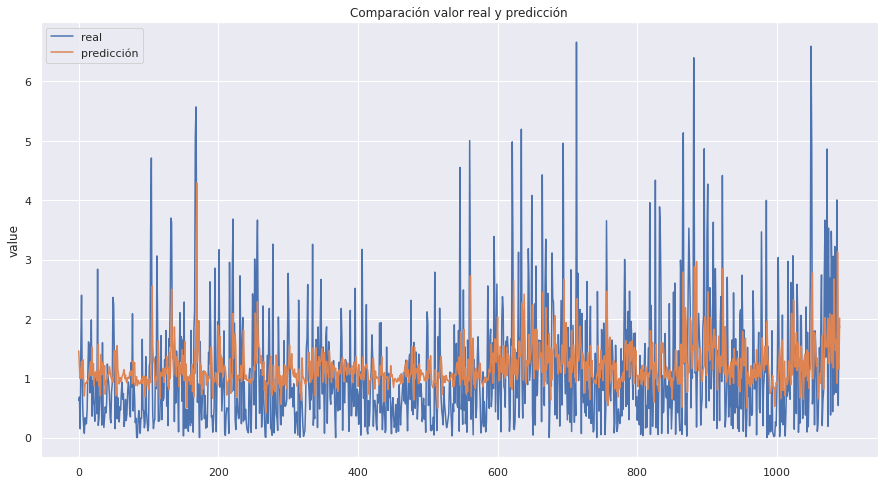

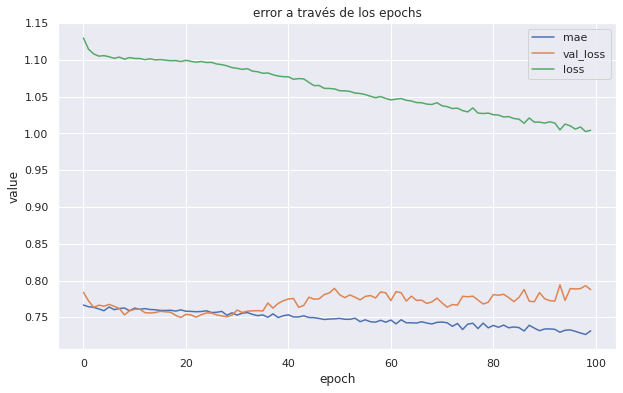

35/35 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.2319582809274434
MAE is : 0.8101498192325839
RMSE is : 1.109936160744141
MAPE is : 39.96563332092013
Evaluation metric results:
MSE is : 1.0076532859173548
MAE is : 0.7584233210540178
RMSE is : 1.0038193492443523
MAPE is : 41.30100456387387
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 3s 10ms/step - loss: 1.1404 - mae: 0.7564 - val_loss: 0.7894 - val_mae: 0.6893
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1292 - mae: 0.7596 - val_loss: 0.7933 - val_mae: 0.6946
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1252 - mae: 0.7632 - val_loss: 0.7935 - val_mae: 0.6950
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1227 - mae: 0.7621 - val_loss: 0.7950 - val_mae: 0.6975
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1210 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0915 - mae: 0.7536 - val_loss: 0.7594 - val_mae: 0.6832
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0913 - mae: 0.7551 - val_loss: 0.7588 - val_mae: 0.6828
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0913 - mae: 0.7557 - val_loss: 0.7603 - val_mae: 0.6849
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0907 - mae: 0.7591 - val_loss: 0.7573 - val_mae: 0.6817
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0905 - mae: 0.7557 - val_loss: 0.7574 - val_mae: 0.6824
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0904 - mae: 0.7583 - val_loss: 0.7567 - val_mae: 0.6808
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0905 - mae: 0.7550 - val_loss: 0.7554 - val_mae: 0.6801
Epoch 66/100
128/128 [==============================] - 1s 7ms

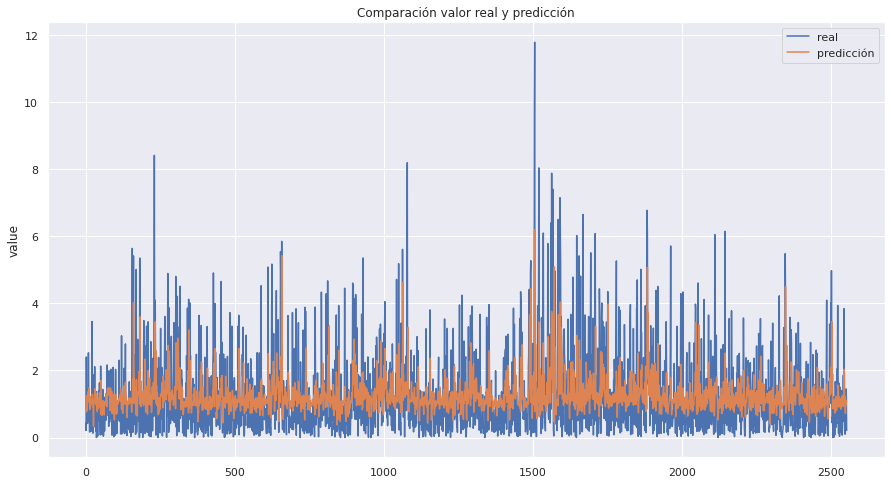

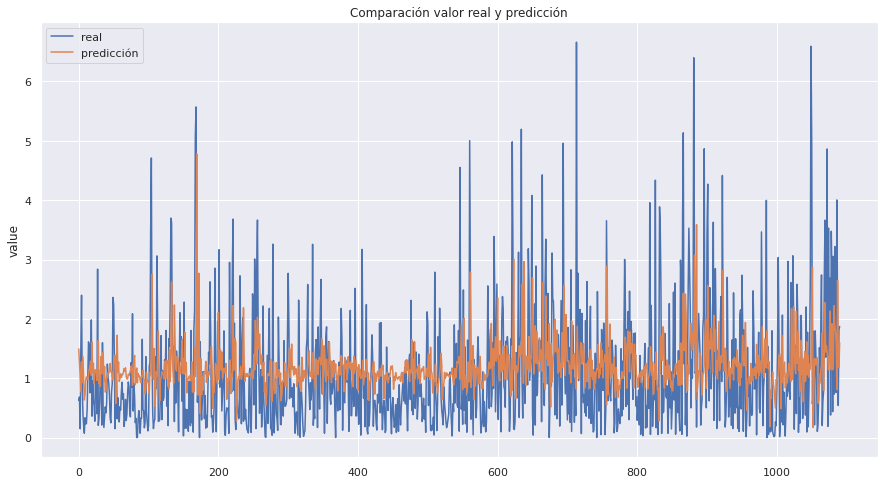

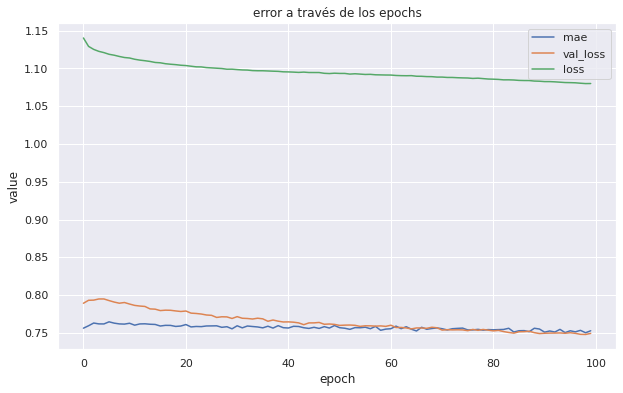

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.313142692003676
MAE is : 0.8394537654280759
RMSE is : 1.145924383196237
MAPE is : 41.758612573632966
Evaluation metric results:
MSE is : 0.9302976096621359
MAE is : 0.737508580439376
RMSE is : 0.9645193671783558
MAPE is : 40.43570958351373
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1846 - mae: 0.7756 - val_loss: 0.8086 - val_mae: 0.7015
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1434 - mae: 0.7697 - val_loss: 0.8077 - val_mae: 0.7024
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1330 - mae: 0.7693 - val_loss: 0.8022 - val_mae: 0.6983
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1267 - mae: 0.7657 - val_loss: 0.8011 - val_mae: 0.7002
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1224 - mae: 0

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0908 - mae: 0.7530 - val_loss: 0.7597 - val_mae: 0.6833
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0906 - mae: 0.7555 - val_loss: 0.7591 - val_mae: 0.6829
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0910 - mae: 0.7569 - val_loss: 0.7604 - val_mae: 0.6851
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0900 - mae: 0.7605 - val_loss: 0.7535 - val_mae: 0.6776
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0899 - mae: 0.7555 - val_loss: 0.7562 - val_mae: 0.6811
Epoch 64/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0895 - mae: 0.7597 - val_loss: 0.7535 - val_mae: 0.6766
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0905 - mae: 0.7546 - val_loss: 0.7530 - val_mae: 0.6775
Epoch 66/100
128/128 [==============================] - 1s 9m

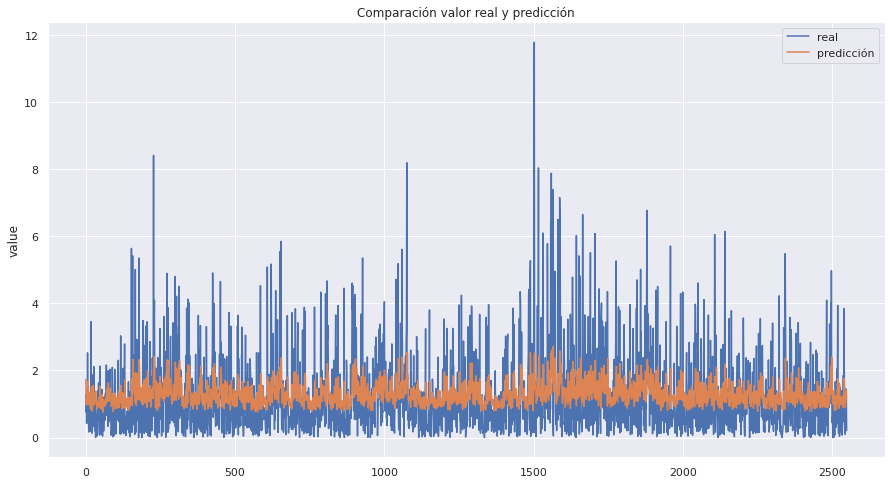

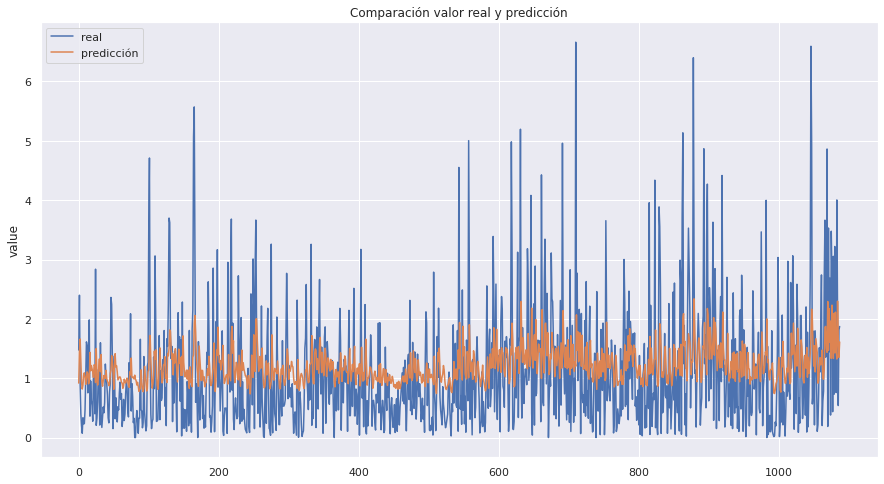

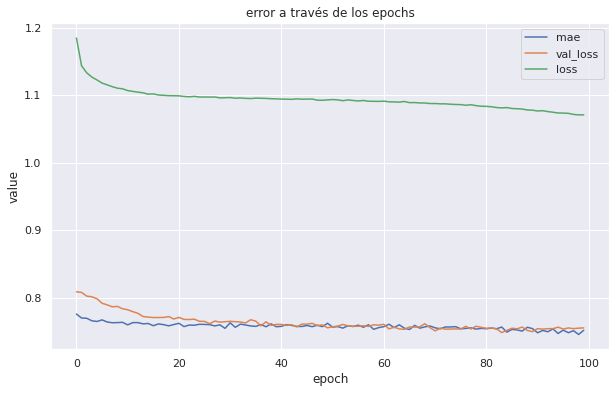

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3021810368603899
MAE is : 0.8344202695450469
RMSE is : 1.1411314722065946
MAPE is : 41.4999135348005
Evaluation metric results:
MSE is : 0.9345141928044163
MAE is : 0.7402456197211597
RMSE is : 0.9667027427314026
MAPE is : 40.55099639386696
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1315 - mae: 0.7583 - val_loss: 0.7917 - val_mae: 0.6929
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1195 - mae: 0.7624 - val_loss: 0.7949 - val_mae: 0.6971
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1162 - mae: 0.7641 - val_loss: 0.7905 - val_mae: 0.6935
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1135 - mae: 0.7620 - val_loss: 0.7933 - val_mae: 0.6987
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1119 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0822 - mae: 0.7497 - val_loss: 0.7530 - val_mae: 0.6776
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0812 - mae: 0.7520 - val_loss: 0.7529 - val_mae: 0.6770
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0814 - mae: 0.7528 - val_loss: 0.7530 - val_mae: 0.6798
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0796 - mae: 0.7564 - val_loss: 0.7481 - val_mae: 0.6731
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0793 - mae: 0.7513 - val_loss: 0.7507 - val_mae: 0.6765
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0778 - mae: 0.7544 - val_loss: 0.7480 - val_mae: 0.6714
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0787 - mae: 0.7492 - val_loss: 0.7484 - val_mae: 0.6731
Epoch 66/100
128/128 [==============================] - 1s 8ms

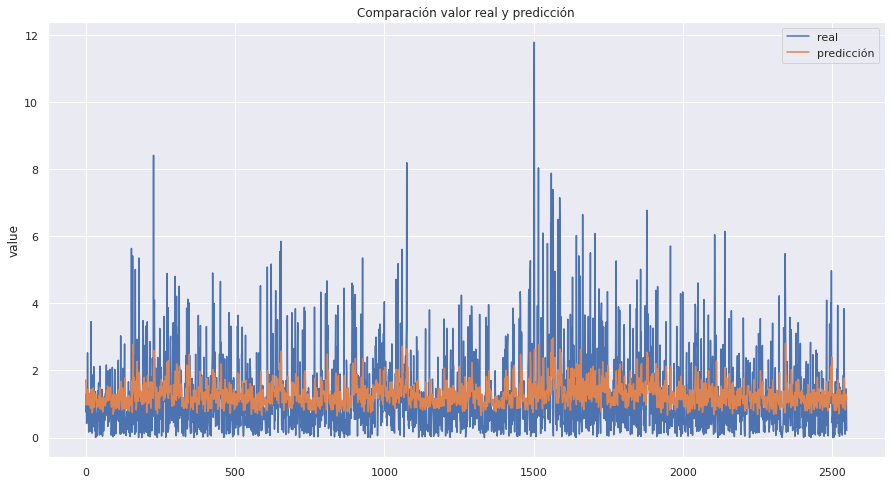

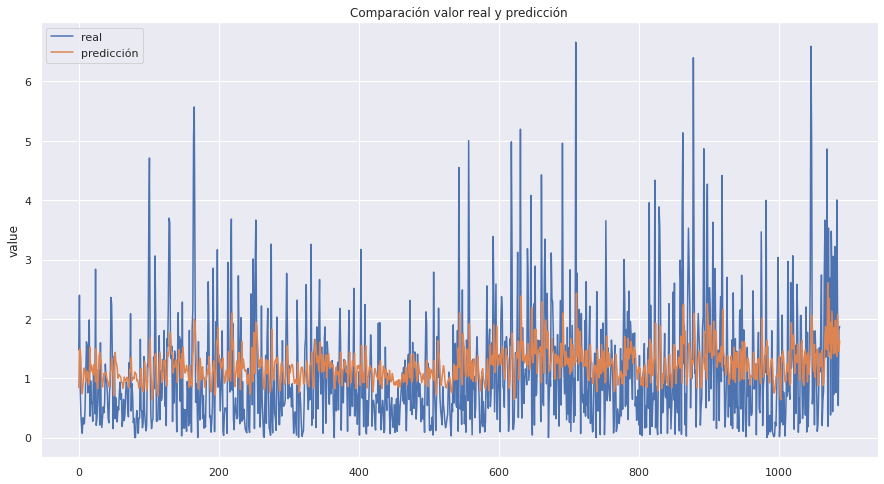

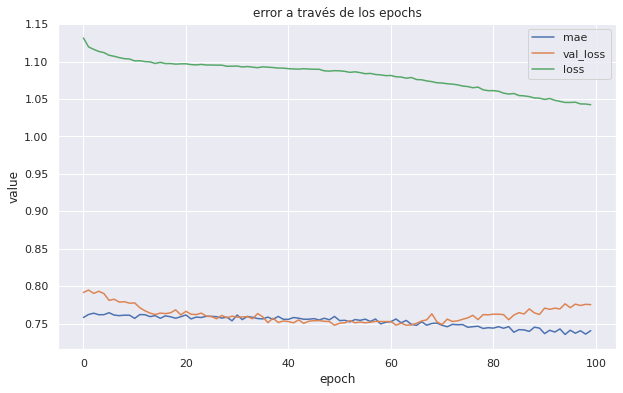

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2751937463061302
MAE is : 0.8255898916509987
RMSE is : 1.1292447681110285
MAPE is : 41.01070325883972
Evaluation metric results:
MSE is : 0.9512706260927729
MAE is : 0.7468641424028548
RMSE is : 0.9753310341072783
MAPE is : 40.78189446811158
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 15ms/step - loss: 1.1296 - mae: 0.7607 - val_loss: 0.7896 - val_mae: 0.6933
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1160 - mae: 0.7632 - val_loss: 0.7931 - val_mae: 0.6971
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1125 - mae: 0.7633 - val_loss: 0.7866 - val_mae: 0.6921
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1093 - mae: 0.7622 - val_loss: 0.7903 - val_mae: 0.6984
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1080 - 

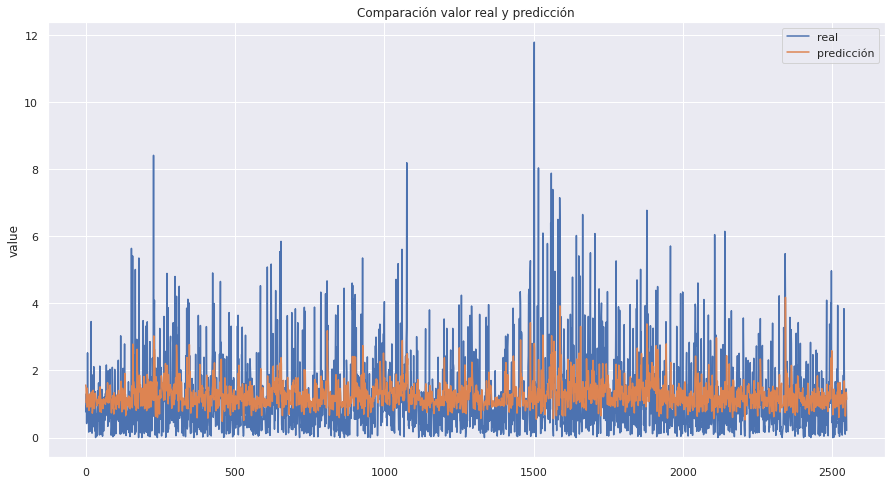

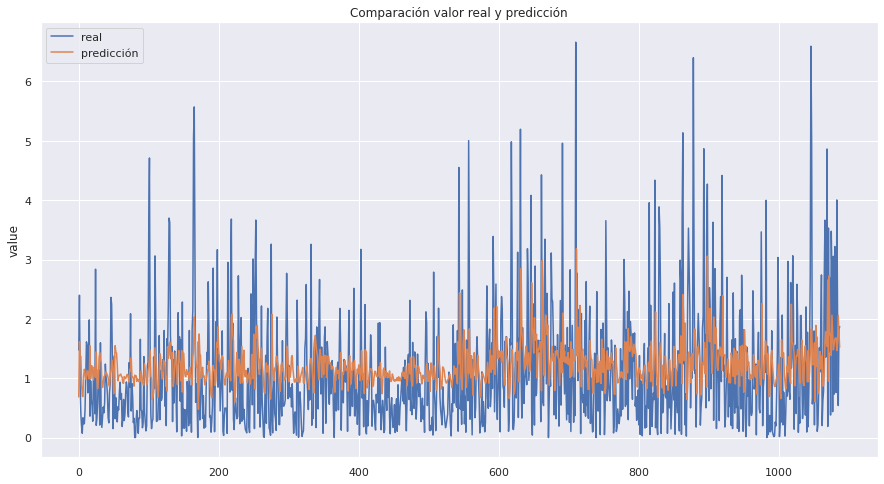

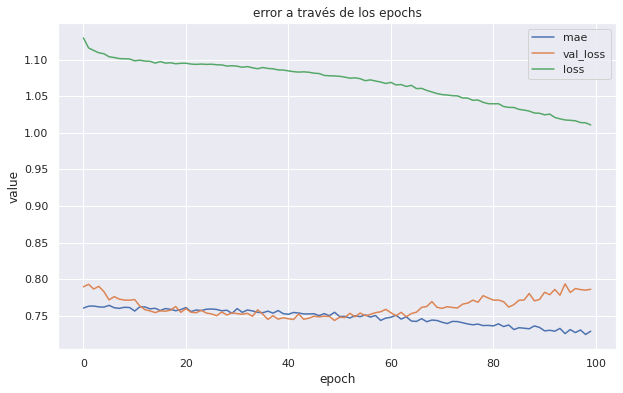

34/34 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.2400889372784607
MAE is : 0.8158005499843993
RMSE is : 1.1135928058668756
MAPE is : 40.686883956974846
Evaluation metric results:
MSE is : 0.9612382309540379
MAE is : 0.7523049609940738
RMSE is : 0.9804275755781443
MAPE is : 41.51181811711547
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 7s 30ms/step - loss: 1.1329 - mae: 0.7626 - val_loss: 0.7891 - val_mae: 0.6936
Epoch 2/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1155 - mae: 0.7638 - val_loss: 0.7904 - val_mae: 0.6956
Epoch 3/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1108 - mae: 0.7625 - val_loss: 0.7824 - val_mae: 0.6904
Epoch 4/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1070 - mae: 0.7622 - val_loss: 0.7857 - val_mae: 0.6967
Epoch 5/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1053 -

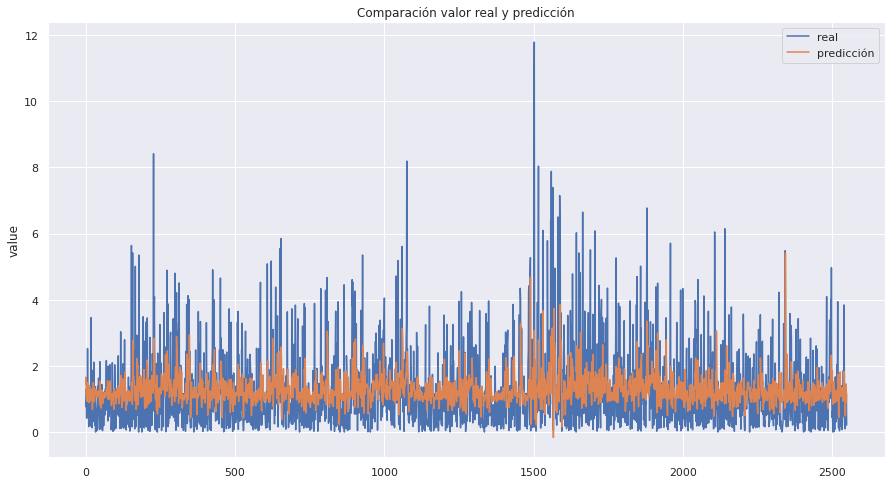

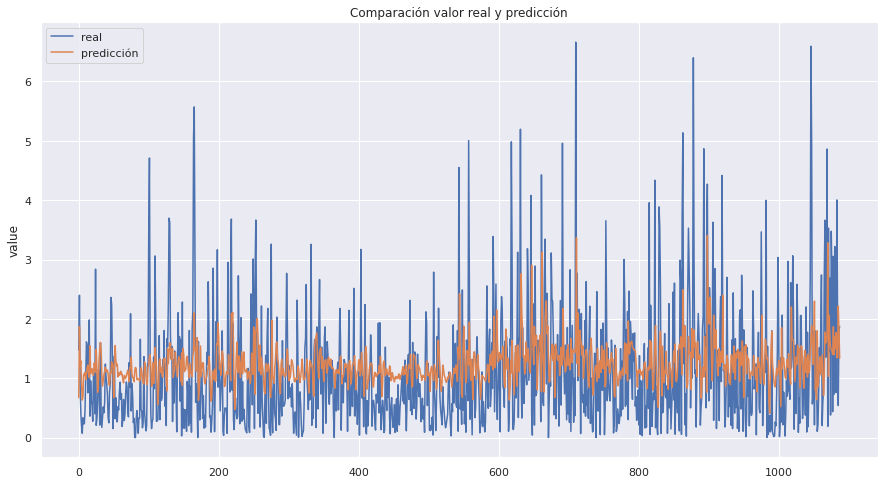

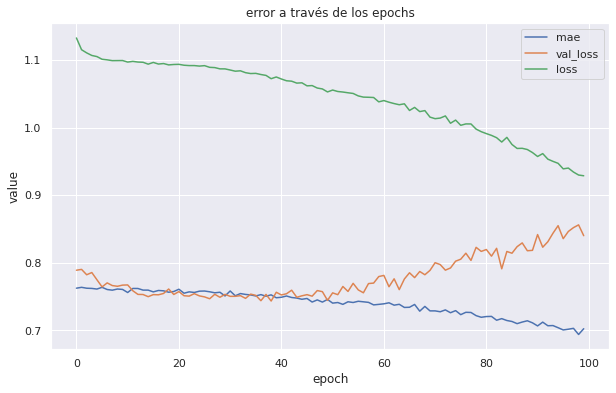

34/34 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 1.1613515792468438
MAE is : 0.7868787655522694
RMSE is : 1.077660233676108
MAPE is : 38.965473458572205
Evaluation metric results:
MSE is : 1.0091943666027812
MAE is : 0.7600953369197798
RMSE is : 1.0045866645555181
MAPE is : 41.66308092789806
(2549, 8, 1) (2549, 1)
(1088, 8, 1) (1088, 1)
Epoch 1/100
128/128 [==============================] - 10s 49ms/step - loss: 1.1329 - mae: 0.7622 - val_loss: 0.7832 - val_mae: 0.6915
Epoch 2/100
128/128 [==============================] - 5s 41ms/step - loss: 1.1109 - mae: 0.7633 - val_loss: 0.7803 - val_mae: 0.6904
Epoch 3/100
128/128 [==============================] - 5s 37ms/step - loss: 1.1059 - mae: 0.7605 - val_loss: 0.7734 - val_mae: 0.6862
Epoch 4/100
128/128 [==============================] - 5s 39ms/step - loss: 1.1030 - mae: 0.7611 - val_loss: 0.7779 - val_mae: 0.6929
Epoch 5/100
128/128 [==============================] - 6s 47ms/step - loss: 1.1020 

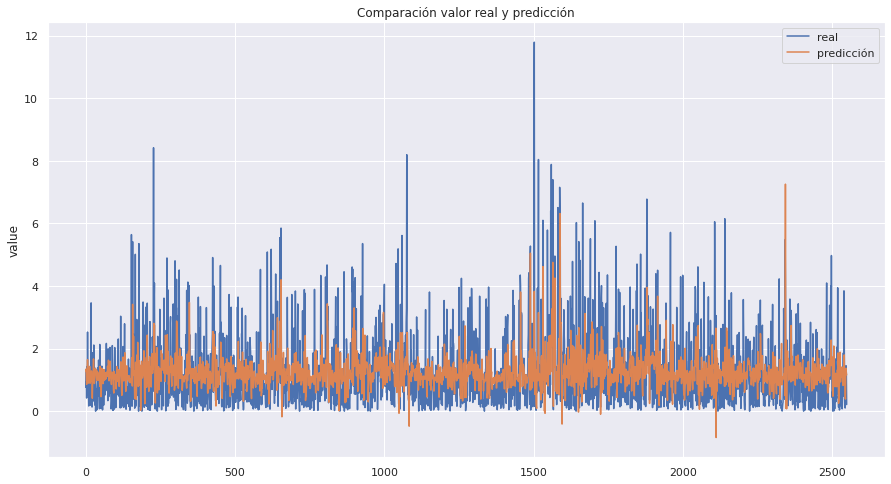

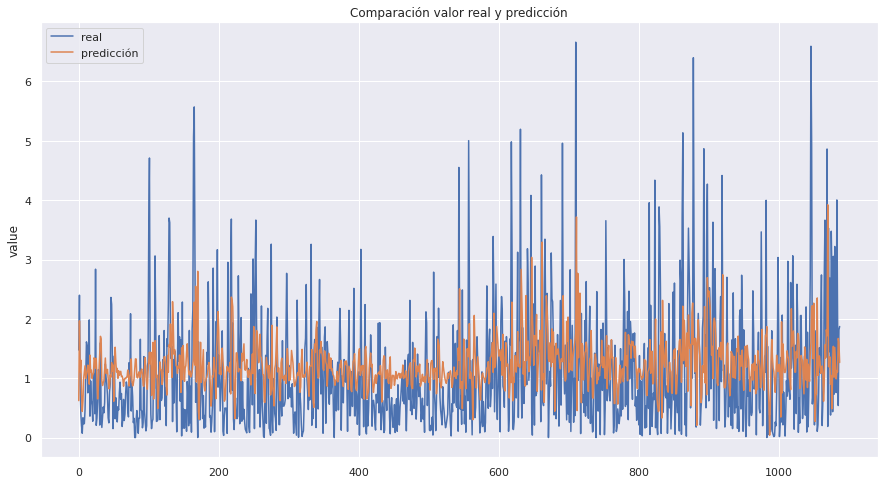

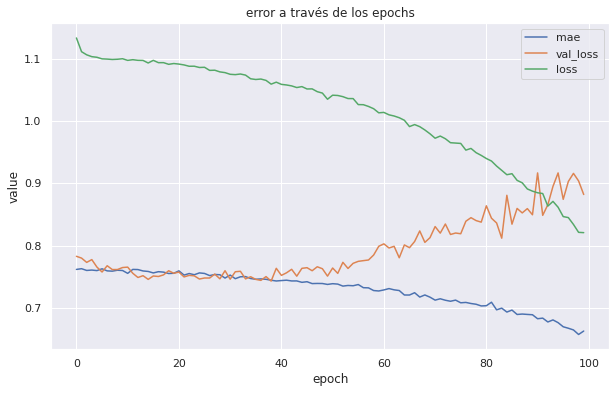

34/34 [==============================] - 1s 16ms/step
Evaluation metric results:
MSE is : 1.0363066579750402
MAE is : 0.7428973343999862
RMSE is : 1.0179914822703775
MAPE is : 37.07052689167703
Evaluation metric results:
MSE is : 1.0622580766279455
MAE is : 0.7769961236237141
RMSE is : 1.030659049651215
MAPE is : 42.5515315349322
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 15ms/step - loss: 1.1724 - mae: 0.7729 - val_loss: 0.8156 - val_mae: 0.7046
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1482 - mae: 0.7732 - val_loss: 0.8139 - val_mae: 0.7069
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1389 - mae: 0.7733 - val_loss: 0.8098 - val_mae: 0.7041
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1334 - mae: 0.7730 - val_loss: 0.8059 - val_mae: 0.7023
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1284 -

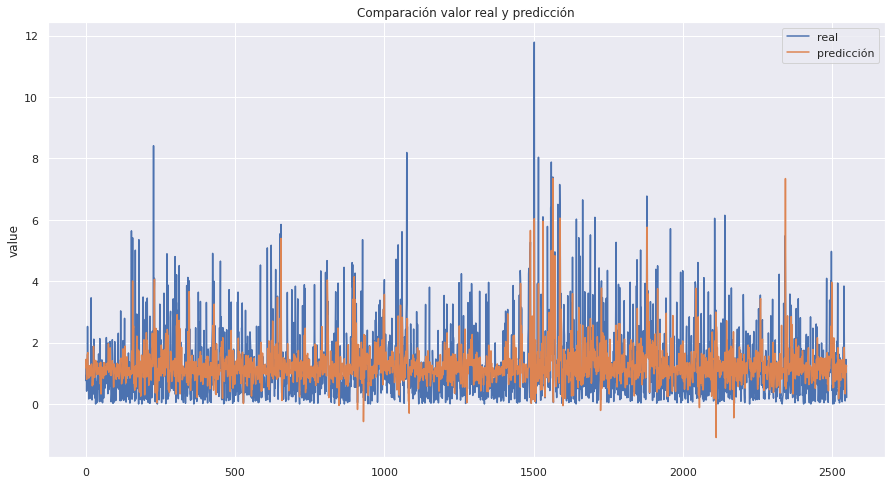

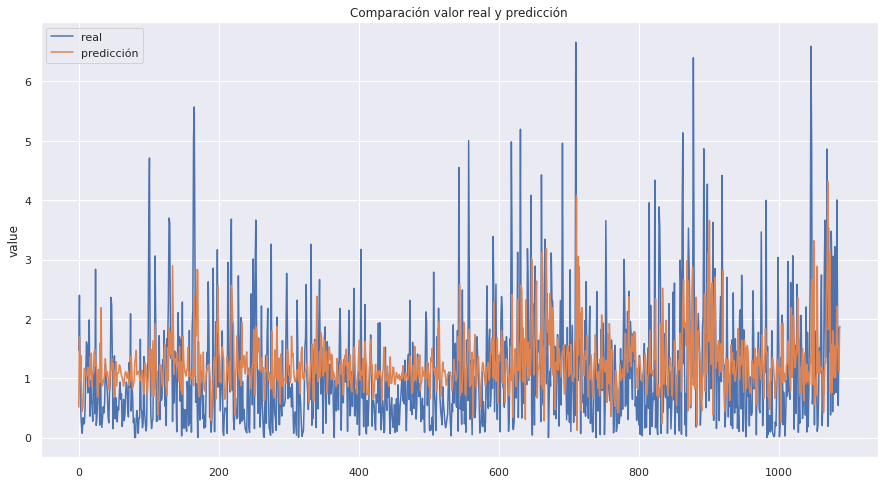

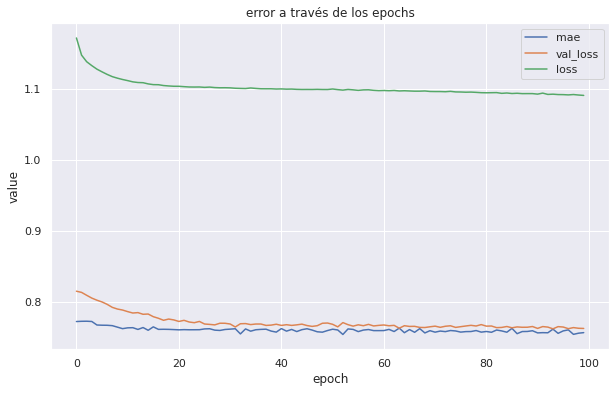

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3289134690160647
MAE is : 0.8441024466072277
RMSE is : 1.1527850922943377
MAPE is : 41.91092867101522
Evaluation metric results:
MSE is : 0.9415468482602071
MAE is : 0.7408365024959727
RMSE is : 0.9703333696520011
MAPE is : 40.419010030909476
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 7s 20ms/step - loss: 1.1496 - mae: 0.7667 - val_loss: 0.8006 - val_mae: 0.6980
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1329 - mae: 0.7667 - val_loss: 0.8013 - val_mae: 0.7002
Epoch 3/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1279 - mae: 0.7669 - val_loss: 0.7987 - val_mae: 0.6981
Epoch 4/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1246 - mae: 0.7677 - val_loss: 0.7965 - val_mae: 0.6970
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1215

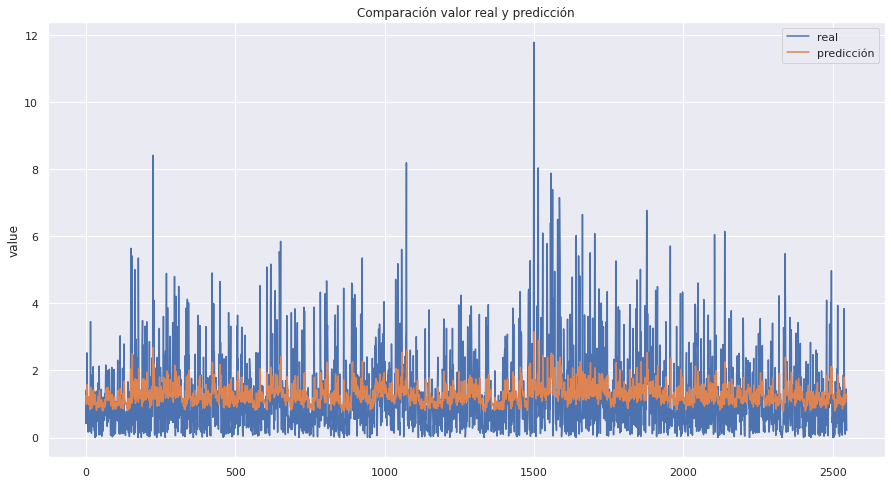

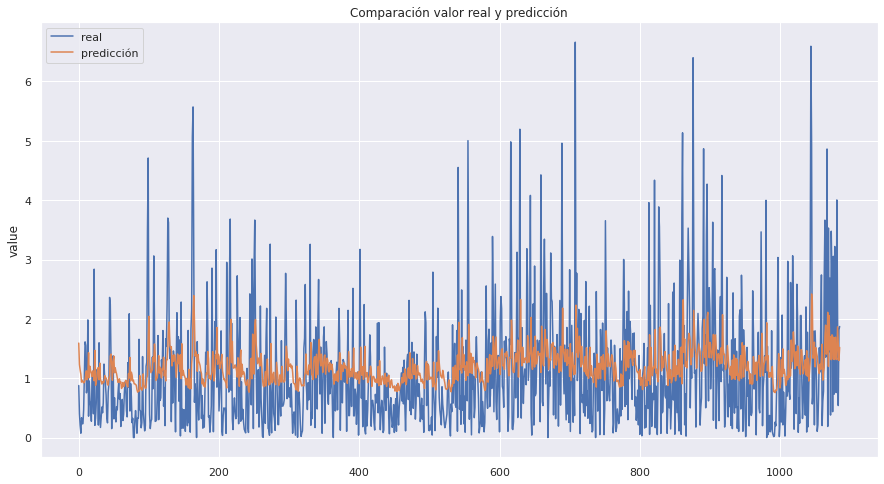

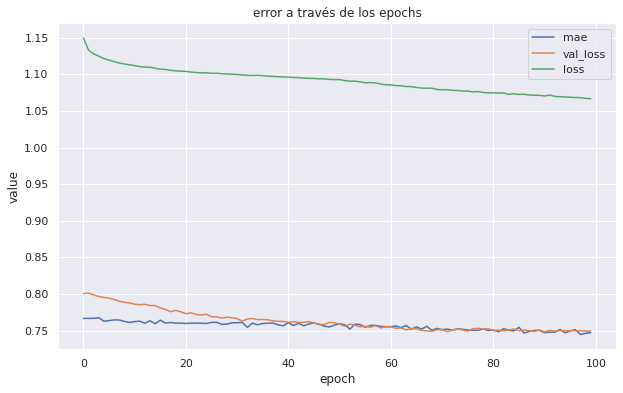

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2983829198639778
MAE is : 0.8323424867067966
RMSE is : 1.1394660678861734
MAPE is : 41.28518100128055
Evaluation metric results:
MSE is : 0.9386730872464625
MAE is : 0.7400754566095796
RMSE is : 0.968851426817581
MAPE is : 40.248306273487174
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1341 - mae: 0.7657 - val_loss: 0.7987 - val_mae: 0.6976
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1231 - mae: 0.7658 - val_loss: 0.7961 - val_mae: 0.6984
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1198 - mae: 0.7655 - val_loss: 0.7909 - val_mae: 0.6947
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1169 - mae: 0.7668 - val_loss: 0.7890 - val_mae: 0.6929
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1141 - ma

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0760 - mae: 0.7519 - val_loss: 0.7521 - val_mae: 0.6788
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0762 - mae: 0.7518 - val_loss: 0.7553 - val_mae: 0.6796
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0762 - mae: 0.7519 - val_loss: 0.7578 - val_mae: 0.6803
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0759 - mae: 0.7537 - val_loss: 0.7516 - val_mae: 0.6790
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0758 - mae: 0.7509 - val_loss: 0.7573 - val_mae: 0.6770
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0759 - mae: 0.7532 - val_loss: 0.7529 - val_mae: 0.6737
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0755 - mae: 0.7497 - val_loss: 0.7546 - val_mae: 0.6788
Epoch 66/100
128/128 [==============================] - 1s 9ms

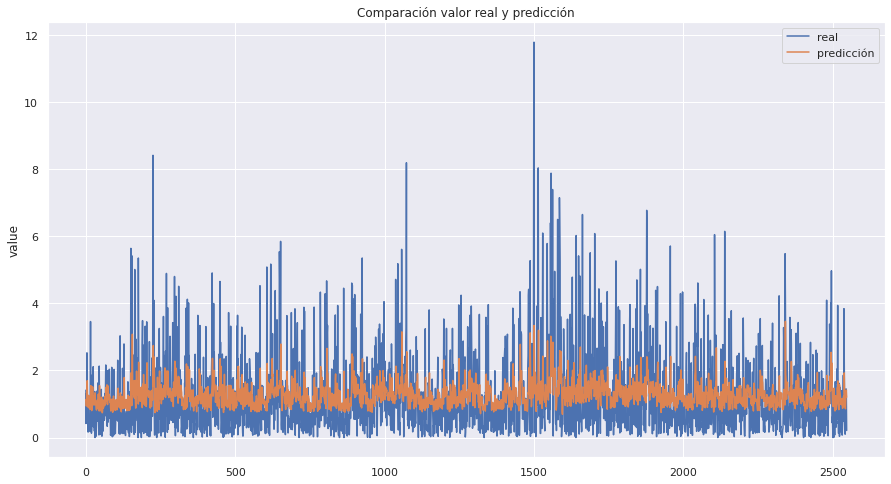

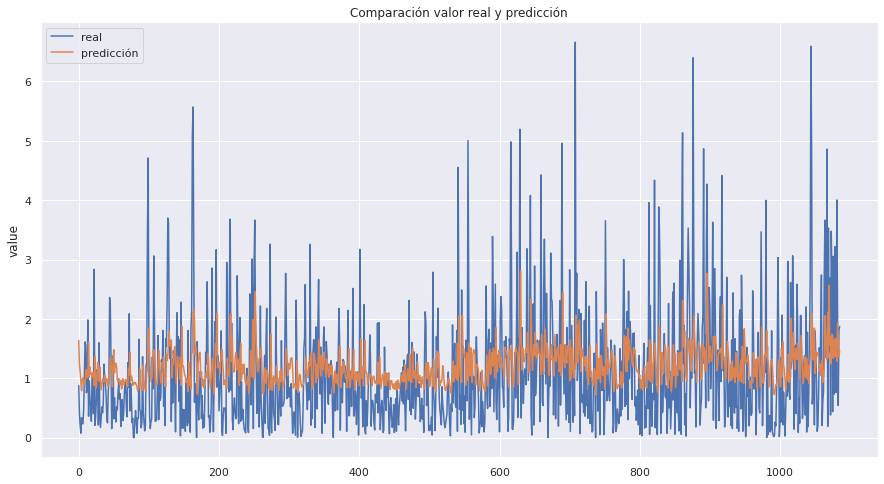

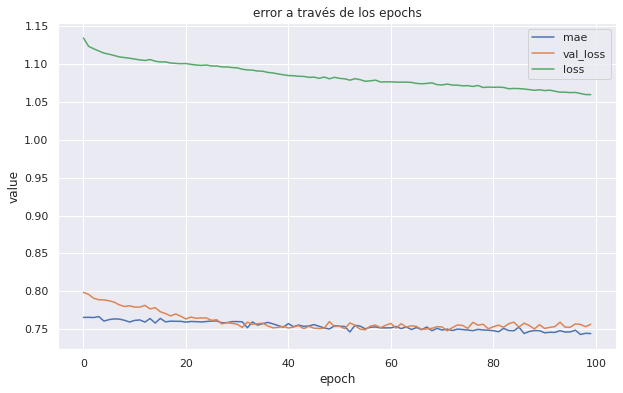

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2906514968386509
MAE is : 0.8303085839498183
RMSE is : 1.1360684384484285
MAPE is : 41.20170470887603
Evaluation metric results:
MSE is : 0.9415976915739849
MAE is : 0.7430496031344437
RMSE is : 0.9703595681879913
MAPE is : 40.551393076636714
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 6s 19ms/step - loss: 1.1343 - mae: 0.7669 - val_loss: 0.7957 - val_mae: 0.6972
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1211 - mae: 0.7656 - val_loss: 0.7928 - val_mae: 0.6976
Epoch 3/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1178 - mae: 0.7650 - val_loss: 0.7844 - val_mae: 0.6921
Epoch 4/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1137 - mae: 0.7663 - val_loss: 0.7829 - val_mae: 0.6890
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1107

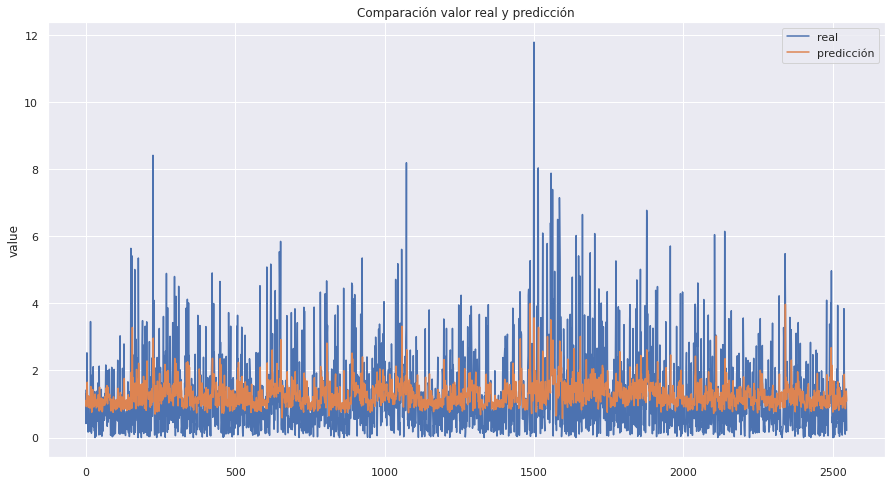

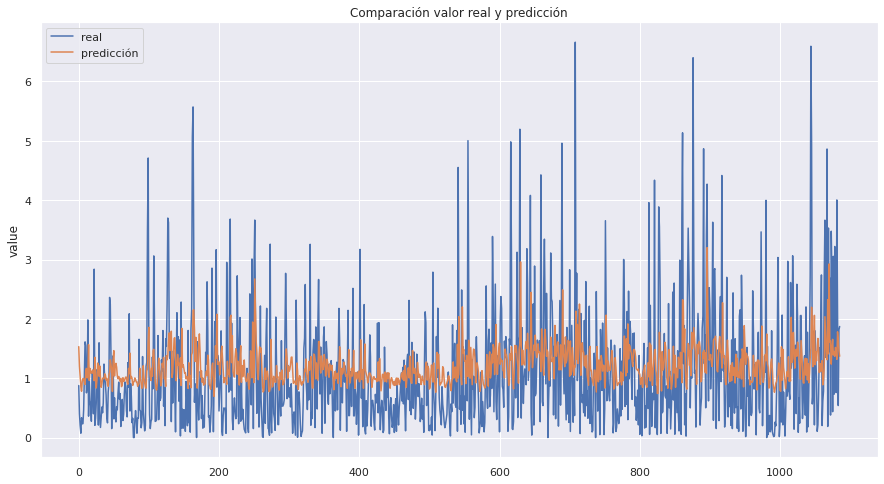

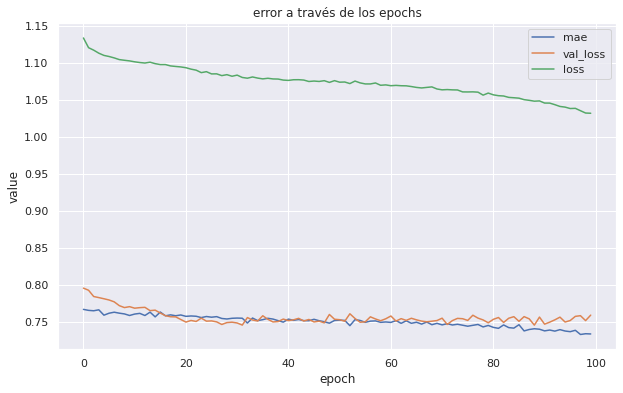

34/34 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.2572463034827117
MAE is : 0.819823613267267
RMSE is : 1.1212699512083215
MAPE is : 40.80132089669473
Evaluation metric results:
MSE is : 0.9573842618689348
MAE is : 0.7475574379907994
RMSE is : 0.9784601483294733
MAPE is : 40.958925815223864
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 7s 29ms/step - loss: 1.1363 - mae: 0.7685 - val_loss: 0.7957 - val_mae: 0.6987
Epoch 2/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1199 - mae: 0.7662 - val_loss: 0.7903 - val_mae: 0.6972
Epoch 3/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1159 - mae: 0.7651 - val_loss: 0.7769 - val_mae: 0.6886
Epoch 4/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1104 - mae: 0.7658 - val_loss: 0.7732 - val_mae: 0.6839
Epoch 5/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1070 

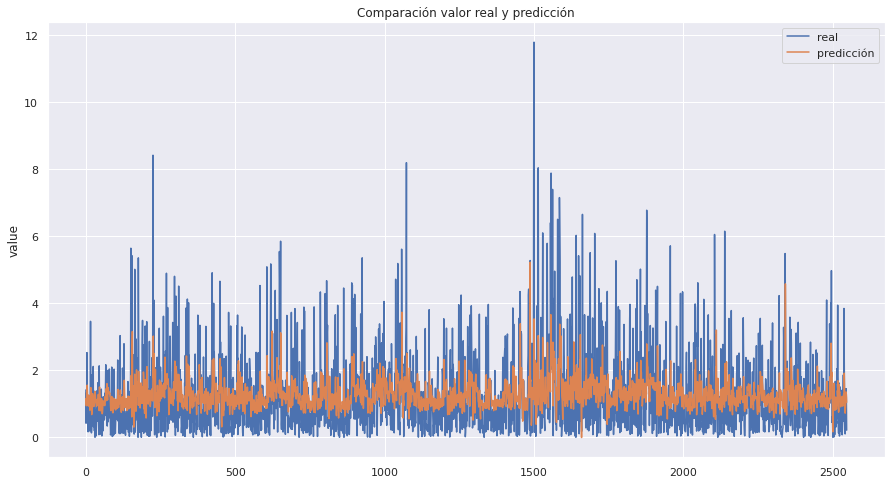

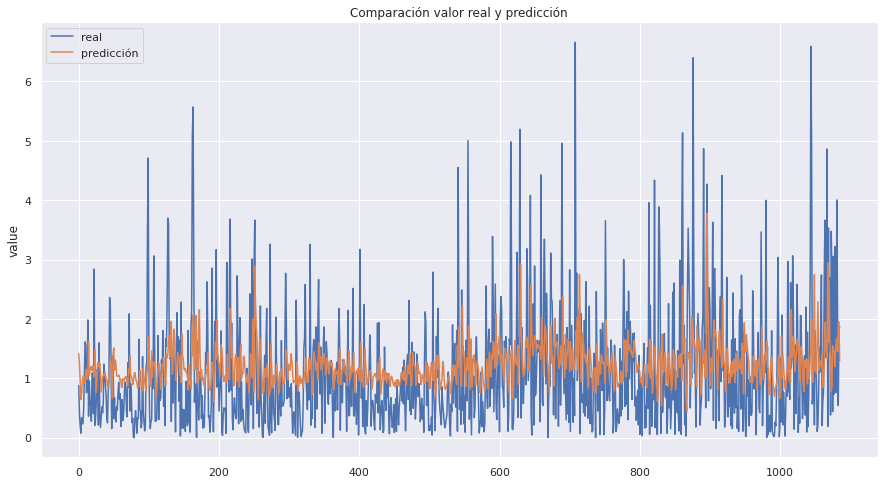

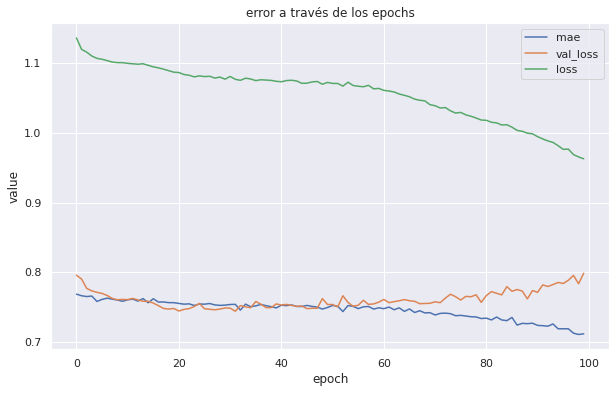

34/34 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.1848997408166342
MAE is : 0.8004968095090045
RMSE is : 1.0885310013116918
MAPE is : 40.1720511629493
Evaluation metric results:
MSE is : 0.983155633832434
MAE is : 0.7561222496828494
RMSE is : 0.9915420484439548
MAPE is : 41.69372255961553
(2547, 10, 1) (2547, 1)
(1086, 10, 1) (1086, 1)
Epoch 1/100
128/128 [==============================] - 8s 39ms/step - loss: 1.1344 - mae: 0.7673 - val_loss: 0.7906 - val_mae: 0.6971
Epoch 2/100
128/128 [==============================] - 4s 34ms/step - loss: 1.1151 - mae: 0.7649 - val_loss: 0.7821 - val_mae: 0.6936
Epoch 3/100
128/128 [==============================] - 4s 34ms/step - loss: 1.1109 - mae: 0.7642 - val_loss: 0.7660 - val_mae: 0.6830
Epoch 4/100
128/128 [==============================] - 4s 34ms/step - loss: 1.1050 - mae: 0.7637 - val_loss: 0.7613 - val_mae: 0.6772
Epoch 5/100
128/128 [==============================] - 4s 34ms/step - loss: 1.1037 - 

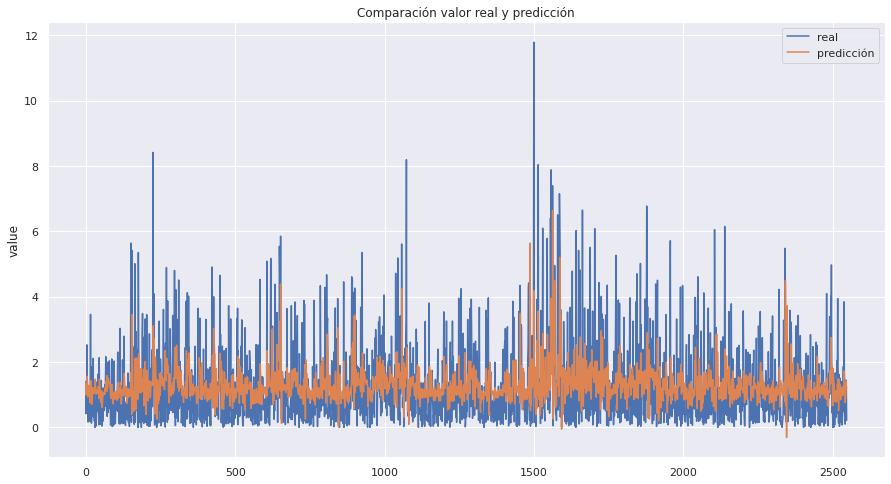

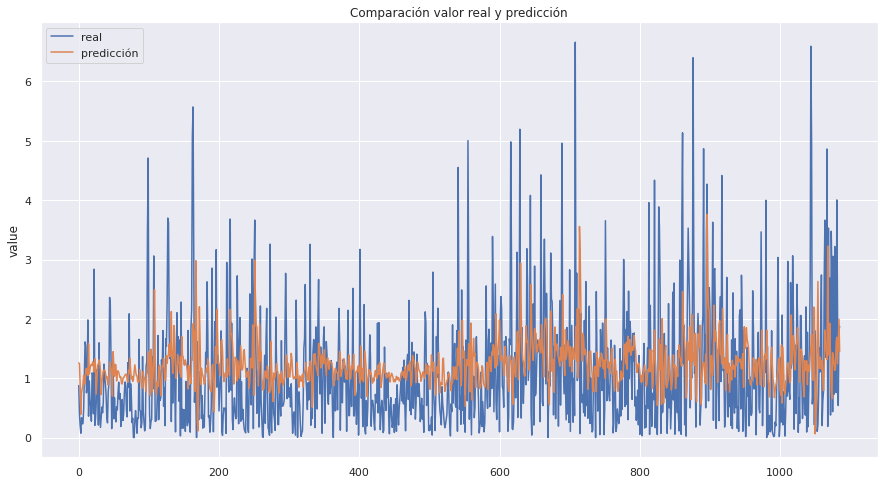

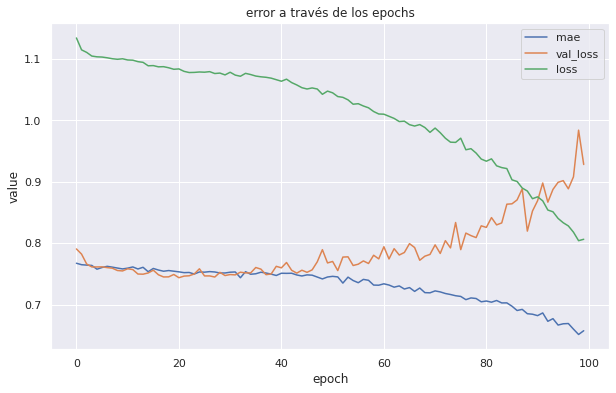

34/34 [==============================] - 0s 13ms/step
Evaluation metric results:
MSE is : 1.0229340485838303
MAE is : 0.7427087839172141
RMSE is : 1.0114020212476493
MAPE is : 37.57801044248836
Evaluation metric results:
MSE is : 1.0975738124862096
MAE is : 0.7922704599667393
RMSE is : 1.0476515701731228
MAPE is : 43.41297997304866
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1396 - mae: 0.7600 - val_loss: 0.7995 - val_mae: 0.6942
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1286 - mae: 0.7663 - val_loss: 0.8013 - val_mae: 0.6967
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1247 - mae: 0.7618 - val_loss: 0.8027 - val_mae: 0.6973
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1212 - mae: 0.7657 - val_loss: 0.8021 - val_mae: 0.6964
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1193 - m

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0864 - mae: 0.7524 - val_loss: 0.7767 - val_mae: 0.6825
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0857 - mae: 0.7549 - val_loss: 0.7772 - val_mae: 0.6825
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0853 - mae: 0.7563 - val_loss: 0.7739 - val_mae: 0.6793
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0859 - mae: 0.7518 - val_loss: 0.7761 - val_mae: 0.6823
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0855 - mae: 0.7544 - val_loss: 0.7737 - val_mae: 0.6792
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0854 - mae: 0.7550 - val_loss: 0.7721 - val_mae: 0.6777
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0858 - mae: 0.7546 - val_loss: 0.7736 - val_mae: 0.6792
Epoch 66/100
128/128 [==============================] - 1s 8ms

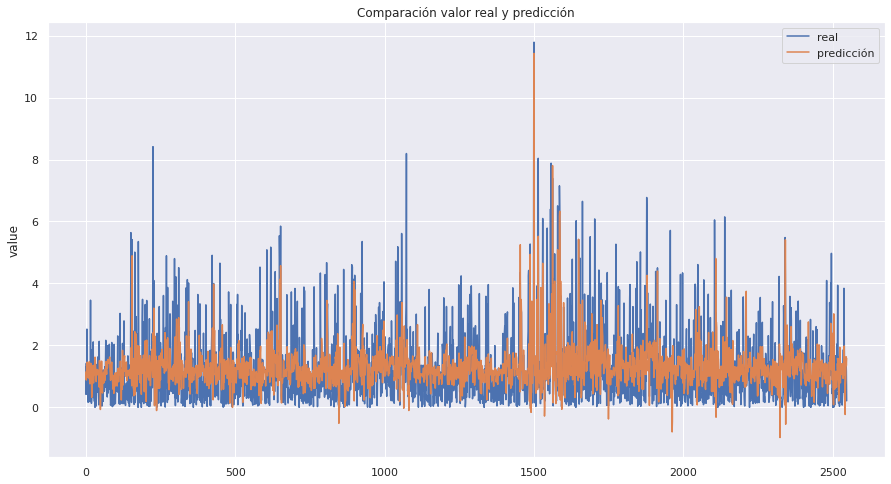

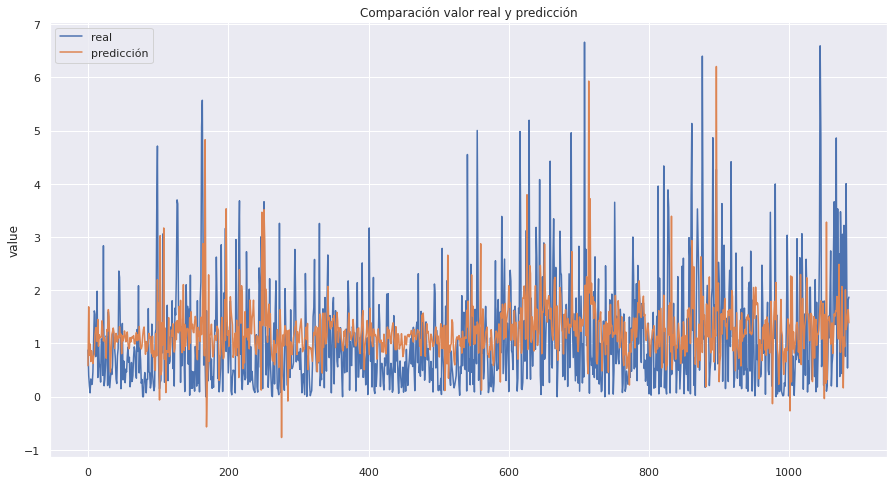

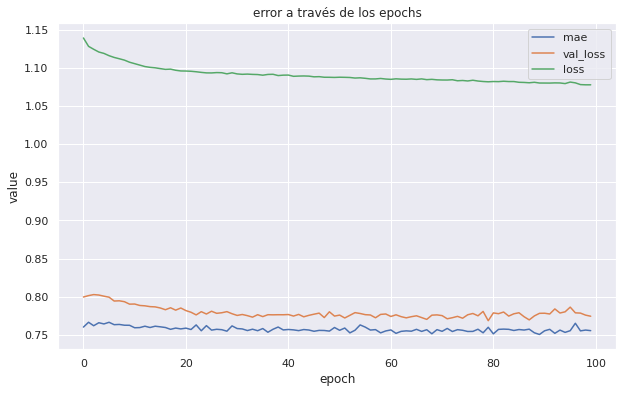

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3176617941043665
MAE is : 0.8398411788087341
RMSE is : 1.1478945047801068
MAPE is : 41.40847368566497
Evaluation metric results:
MSE is : 0.9374201626619382
MAE is : 0.7323025974166893
RMSE is : 0.9682046078499824
MAPE is : 39.522844857095166
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1343 - mae: 0.7642 - val_loss: 0.8038 - val_mae: 0.6972
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1212 - mae: 0.7711 - val_loss: 0.7996 - val_mae: 0.6967
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1155 - mae: 0.7623 - val_loss: 0.8020 - val_mae: 0.6978
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1116 - mae: 0.7681 - val_loss: 0.7969 - val_mae: 0.6939
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1089 - m

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0780 - mae: 0.7514 - val_loss: 0.7749 - val_mae: 0.6827
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0751 - mae: 0.7537 - val_loss: 0.7769 - val_mae: 0.6842
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0751 - mae: 0.7562 - val_loss: 0.7739 - val_mae: 0.6809
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0762 - mae: 0.7508 - val_loss: 0.7775 - val_mae: 0.6859
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0752 - mae: 0.7554 - val_loss: 0.7728 - val_mae: 0.6802
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0753 - mae: 0.7531 - val_loss: 0.7706 - val_mae: 0.6788
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0765 - mae: 0.7528 - val_loss: 0.7757 - val_mae: 0.6834
Epoch 66/100
128/128 [==============================] - 1s 9ms

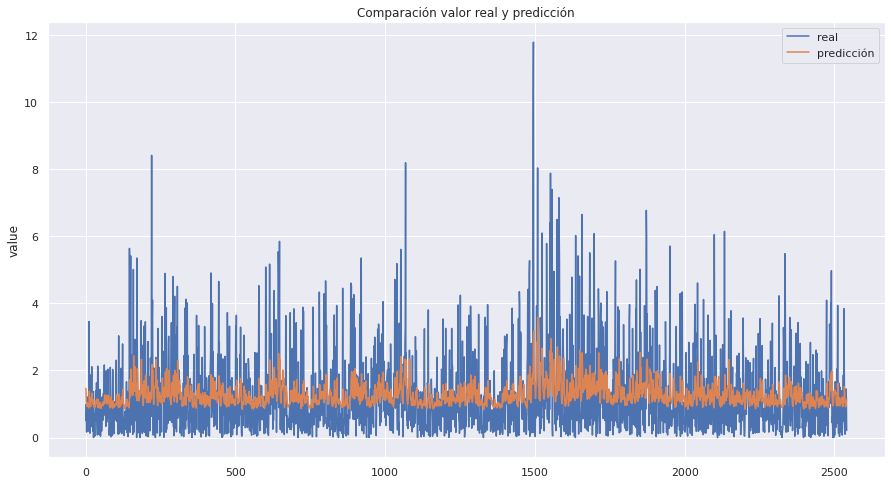

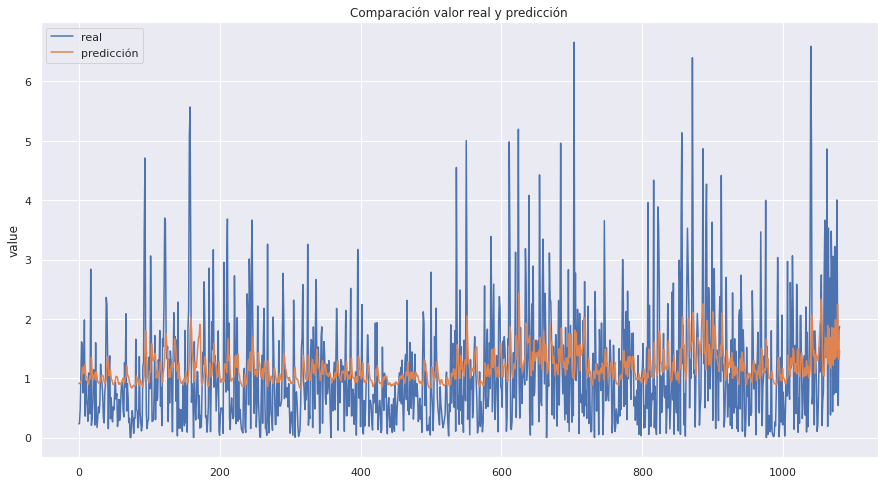

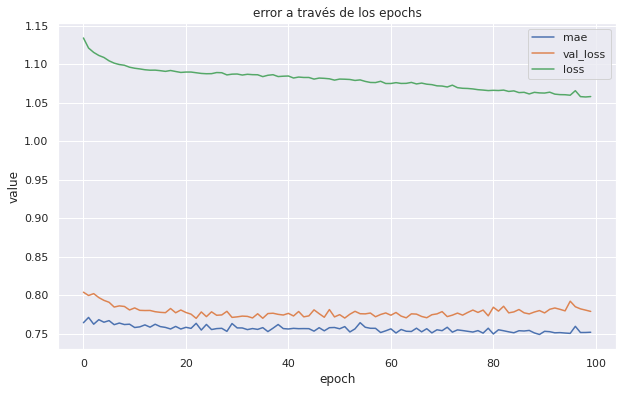

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.296366139166255
MAE is : 0.8389677180376172
RMSE is : 1.1385807565413422
MAPE is : 41.505693505155115
Evaluation metric results:
MSE is : 0.9281878287216935
MAE is : 0.7262816221542215
RMSE is : 0.9634250509103931
MAPE is : 39.197979661353415
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1311 - mae: 0.7625 - val_loss: 0.8082 - val_mae: 0.6966
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1198 - mae: 0.7691 - val_loss: 0.7953 - val_mae: 0.6940
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1121 - mae: 0.7584 - val_loss: 0.8083 - val_mae: 0.6974
Epoch 4/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1104 - mae: 0.7658 - val_loss: 0.7950 - val_mae: 0.6911
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1078

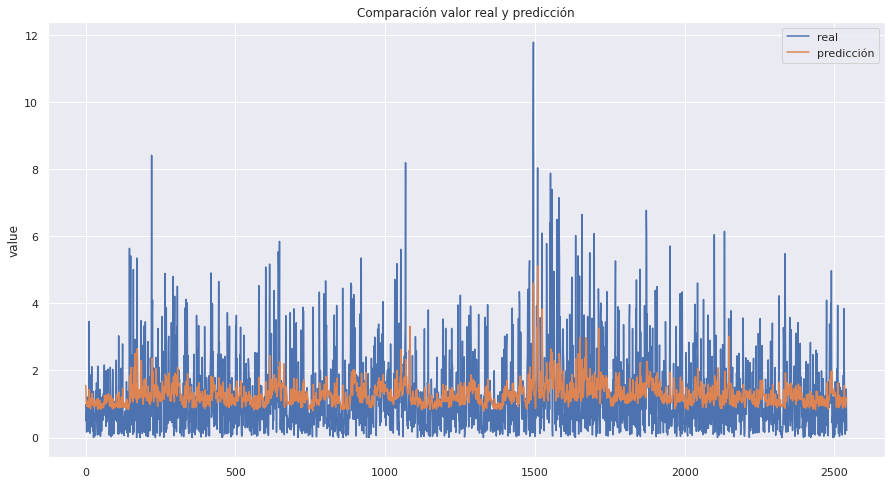

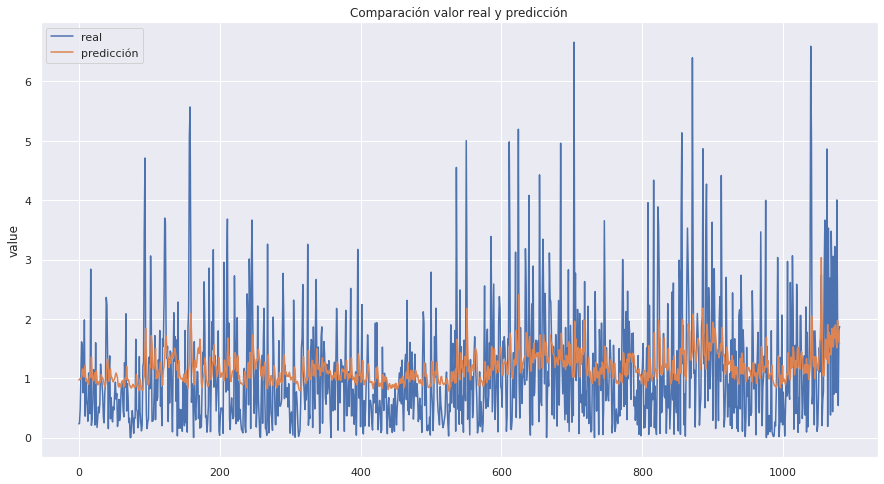

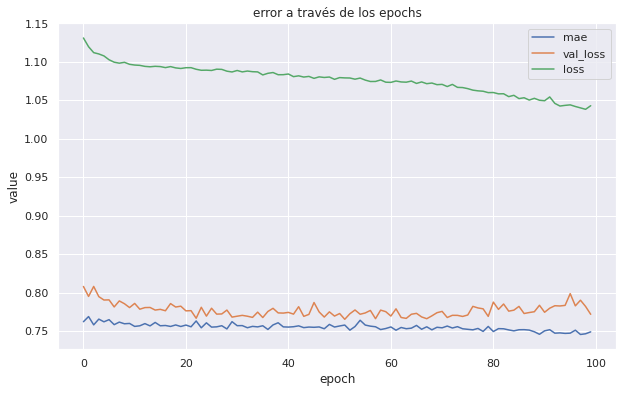

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.2759518247361805
MAE is : 0.8336475106461865
RMSE is : 1.1295803755094989
MAPE is : 41.19411350469592
Evaluation metric results:
MSE is : 0.9274356843828944
MAE is : 0.7277055400641704
RMSE is : 0.9630346226293707
MAPE is : 39.24312096812654
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 8s 27ms/step - loss: 1.1321 - mae: 0.7649 - val_loss: 0.8047 - val_mae: 0.6952
Epoch 2/100
128/128 [==============================] - 2s 20ms/step - loss: 1.1188 - mae: 0.7697 - val_loss: 0.7880 - val_mae: 0.6908
Epoch 3/100
128/128 [==============================] - 3s 21ms/step - loss: 1.1056 - mae: 0.7566 - val_loss: 0.8202 - val_mae: 0.7037
Epoch 4/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1063 - mae: 0.7649 - val_loss: 0.7876 - val_mae: 0.6875
Epoch 5/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1055 

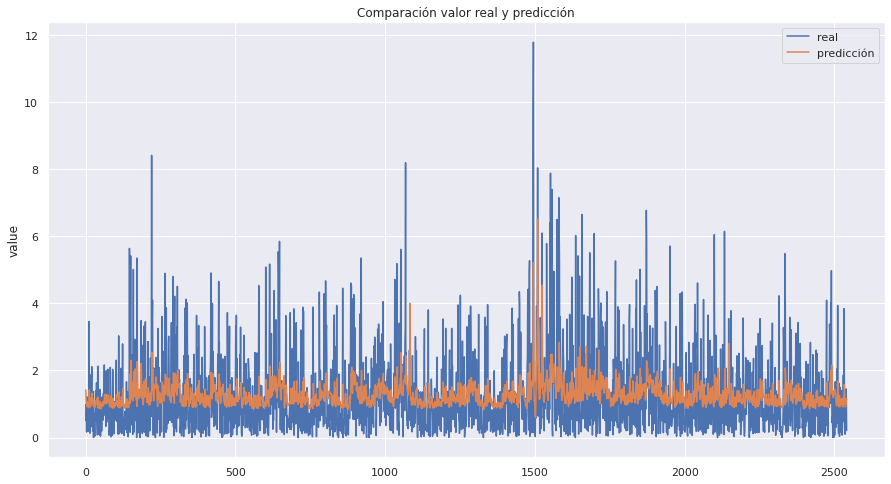

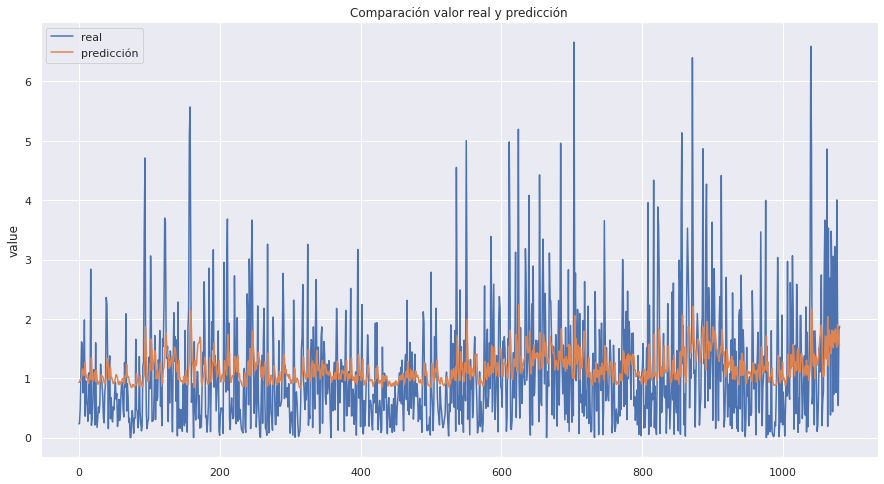

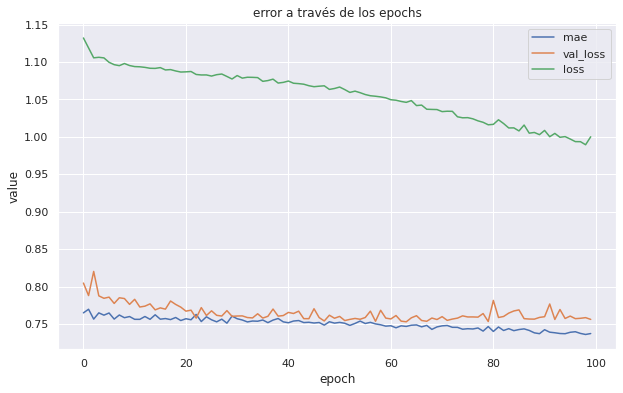

34/34 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.221595061132584
MAE is : 0.8267692491915313
RMSE is : 1.1052579161139648
MAPE is : 41.4191882573907
Evaluation metric results:
MSE is : 0.9273278974630549
MAE is : 0.7319062290431035
RMSE is : 0.9629786588824567
MAPE is : 39.86392904508514
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 8s 40ms/step - loss: 1.1310 - mae: 0.7643 - val_loss: 0.7949 - val_mae: 0.6914
Epoch 2/100
128/128 [==============================] - 5s 36ms/step - loss: 1.1193 - mae: 0.7701 - val_loss: 0.7817 - val_mae: 0.6889
Epoch 3/100
128/128 [==============================] - 5s 36ms/step - loss: 1.1027 - mae: 0.7562 - val_loss: 0.8116 - val_mae: 0.7022
Epoch 4/100
128/128 [==============================] - 4s 30ms/step - loss: 1.1032 - mae: 0.7625 - val_loss: 0.7810 - val_mae: 0.6860
Epoch 5/100
128/128 [==============================] - 4s 31ms/step - loss: 1.1041 - 

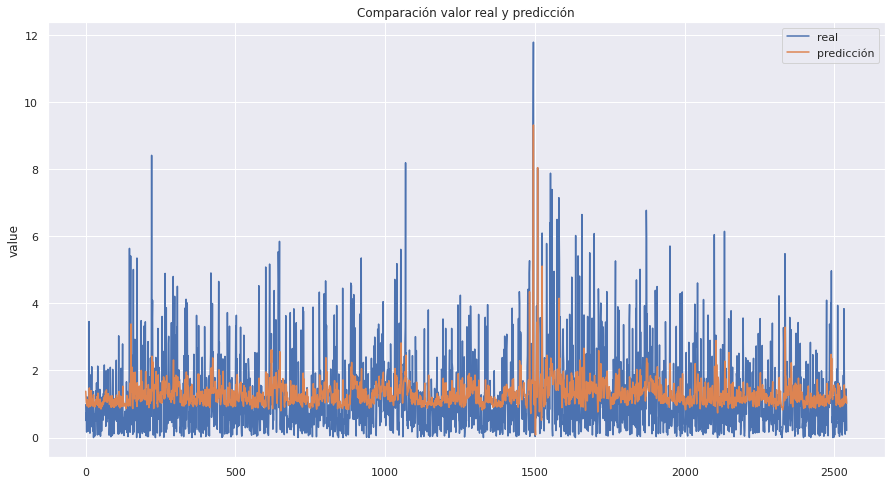

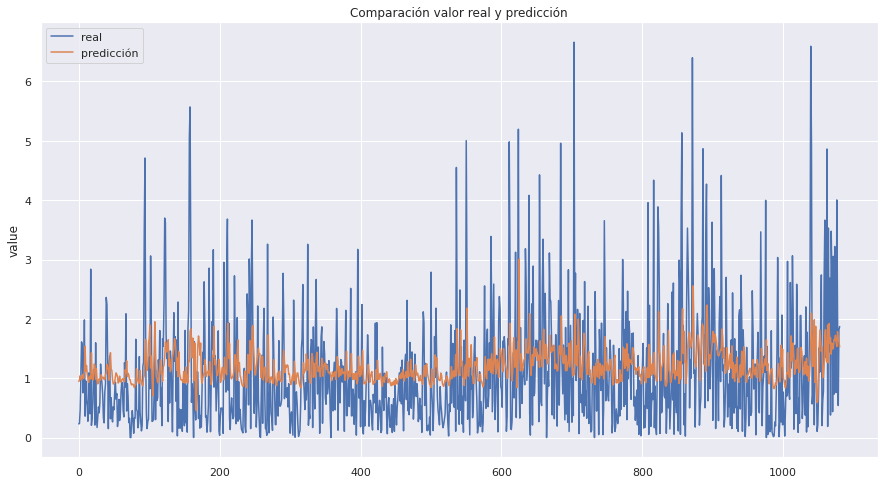

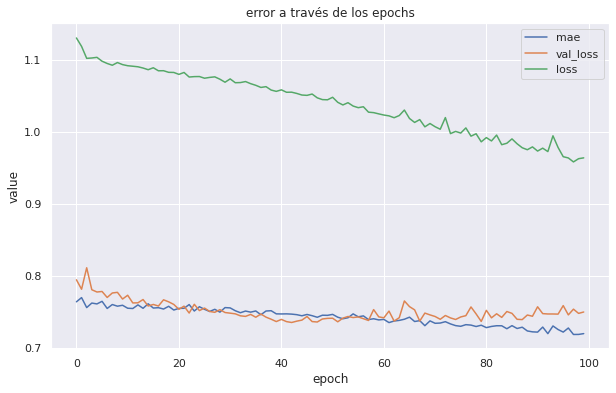

34/34 [==============================] - 1s 19ms/step
Evaluation metric results:
MSE is : 1.178260062113711
MAE is : 0.8108015746877373
RMSE is : 1.0854768823488186
MAPE is : 40.966358409086496
Evaluation metric results:
MSE is : 0.947325716471296
MAE is : 0.7503745426606164
RMSE is : 0.9733065891440867
MAPE is : 41.33125263163949
(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 19s 100ms/step - loss: 1.1271 - mae: 0.7635 - val_loss: 0.7840 - val_mae: 0.6888
Epoch 2/100
128/128 [==============================] - 12s 92ms/step - loss: 1.1219 - mae: 0.7713 - val_loss: 0.7758 - val_mae: 0.6867
Epoch 3/100
128/128 [==============================] - 12s 96ms/step - loss: 1.1022 - mae: 0.7554 - val_loss: 0.7967 - val_mae: 0.6969
Epoch 4/100
128/128 [==============================] - 14s 110ms/step - loss: 1.1005 - mae: 0.7602 - val_loss: 0.7748 - val_mae: 0.6826
Epoch 5/100
128/128 [==============================] - 15s 117ms/step - loss:

Epoch 58/100
128/128 [==============================] - 19s 146ms/step - loss: 1.0109 - mae: 0.7334 - val_loss: 0.7293 - val_mae: 0.6576
Epoch 59/100
128/128 [==============================] - 18s 141ms/step - loss: 1.0328 - mae: 0.7407 - val_loss: 0.7446 - val_mae: 0.6672
Epoch 60/100
128/128 [==============================] - 18s 143ms/step - loss: 1.0107 - mae: 0.7352 - val_loss: 0.7346 - val_mae: 0.6667
Epoch 61/100
128/128 [==============================] - 18s 141ms/step - loss: 1.0115 - mae: 0.7359 - val_loss: 0.7322 - val_mae: 0.6616
Epoch 62/100
128/128 [==============================] - 17s 129ms/step - loss: 1.0077 - mae: 0.7300 - val_loss: 0.7435 - val_mae: 0.6671
Epoch 63/100
128/128 [==============================] - 16s 124ms/step - loss: 1.0014 - mae: 0.7317 - val_loss: 0.7330 - val_mae: 0.6573
Epoch 64/100
128/128 [==============================] - 16s 124ms/step - loss: 0.9960 - mae: 0.7323 - val_loss: 0.7344 - val_mae: 0.6578
Epoch 65/100
128/128 [===================

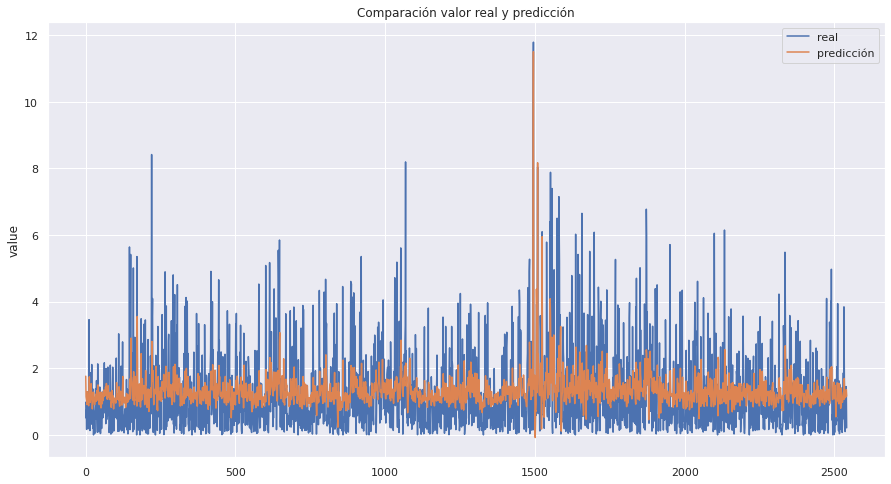

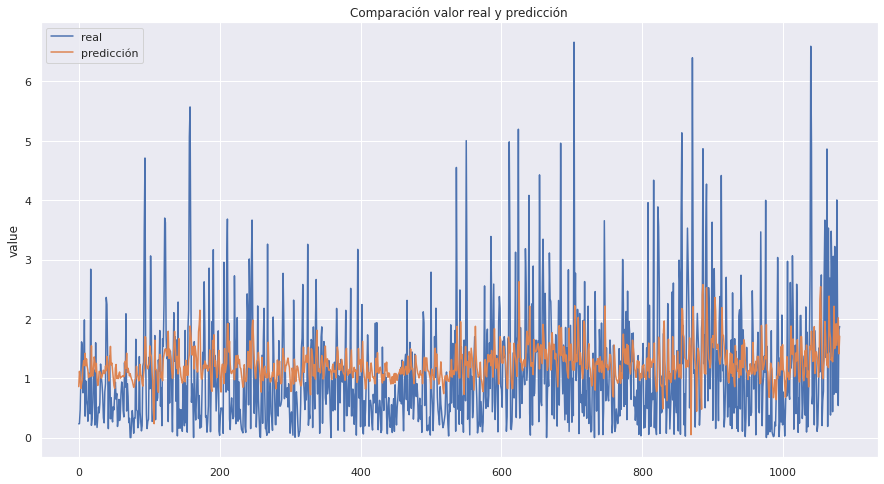

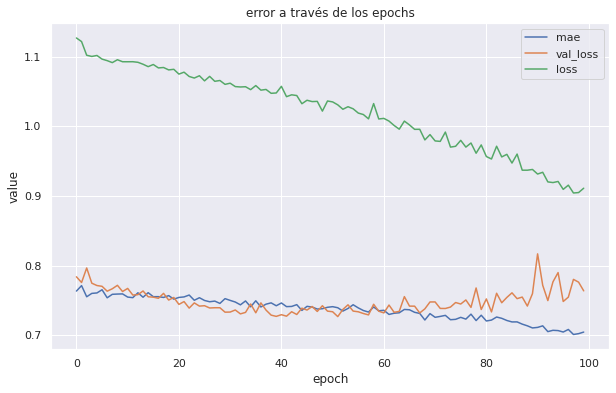

34/34 [==============================] - 2s 53ms/step
Evaluation metric results:
MSE is : 1.104730030516496
MAE is : 0.7845880692783846
RMSE is : 1.051061382849021
MAPE is : 39.445120125321296
Evaluation metric results:
MSE is : 0.9981064608929542
MAE is : 0.7551574694050368
RMSE is : 0.9990527818353514
MAPE is : 41.07460097709983


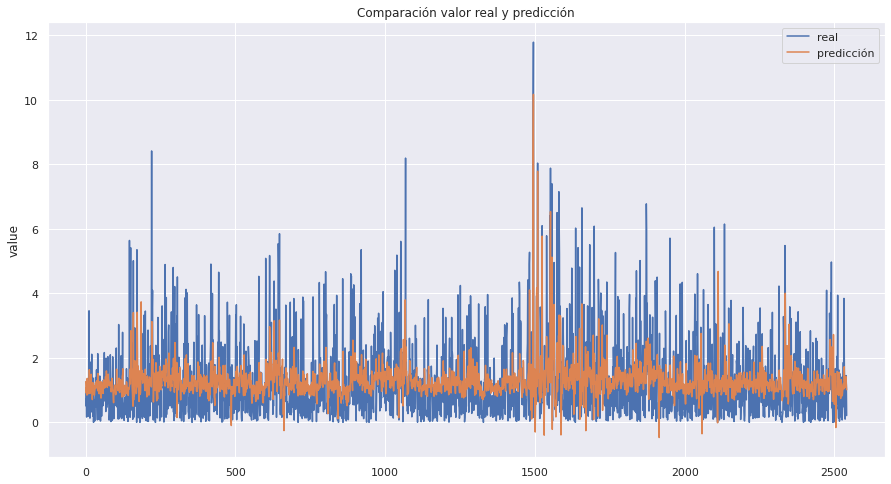

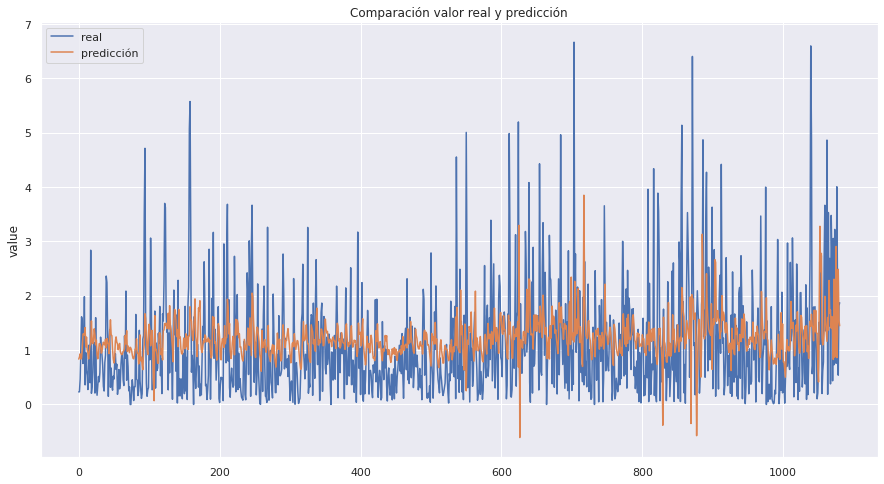

In [14]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=1,epochss=100,batch_sizze=16,lag=lg)

In [15]:
import json
path="./resultsLSTM/volatilidadAntes/"

In [16]:
for i in lags:
    with open(path+f"lag{i}.json", "w") as outfile:
        json.dump(results_models[i], outfile)

A continuación graficamos el comportamiento tanto del error cuadrático medio como del error absoluto medio, donde se observa que el error cae drásticamente en los primeros epochs y luego el error absoluto medio sigue decayendo pero en una proporción mucho menor.

Save result models for each dataset

(2542, 15, 1) (2542, 1)
(1081, 15, 1) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.2292 - mae: 0.7920 - val_loss: 0.8380 - val_mae: 0.7146
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1689 - mae: 0.7866 - val_loss: 0.8336 - val_mae: 0.7120
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1505 - mae: 0.7753 - val_loss: 0.8313 - val_mae: 0.7107
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1393 - mae: 0.7782 - val_loss: 0.8225 - val_mae: 0.7040
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1326 - mae: 0.7734 - val_loss: 0.8164 - val_mae: 0.7021
Epoch 6/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1255 - mae: 0.7743 - val_loss: 0.8109 - val_mae: 0.6995
Epoch 7/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1200 - mae: 0.7676 - val_loss: 0.8028 - val_mae: 0.6954
Epoch 8/100
128/128 

Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0850 - mae: 0.7517 - val_loss: 0.7706 - val_mae: 0.6848
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0846 - mae: 0.7559 - val_loss: 0.7651 - val_mae: 0.6770
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0843 - mae: 0.7551 - val_loss: 0.7634 - val_mae: 0.6758
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0853 - mae: 0.7552 - val_loss: 0.7665 - val_mae: 0.6795
Epoch 66/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0845 - mae: 0.7584 - val_loss: 0.7671 - val_mae: 0.6811
Epoch 67/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0850 - mae: 0.7536 - val_loss: 0.7651 - val_mae: 0.6776
Epoch 68/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0829 - mae: 0.7580 - val_loss: 0.7611 - val_mae: 0.6694
Epoch 69/100
128/128 [==============================] - 1s 8ms

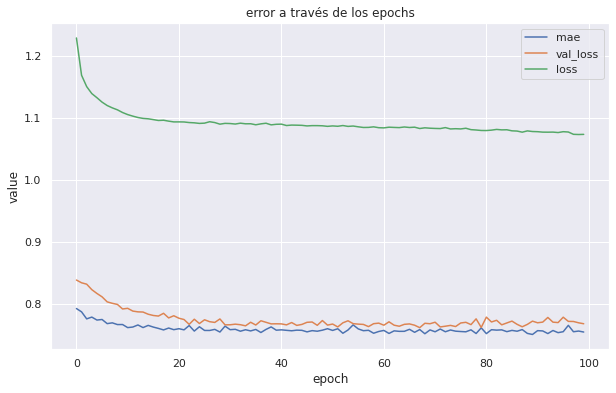

34/34 [==============================] - 0s 3ms/step


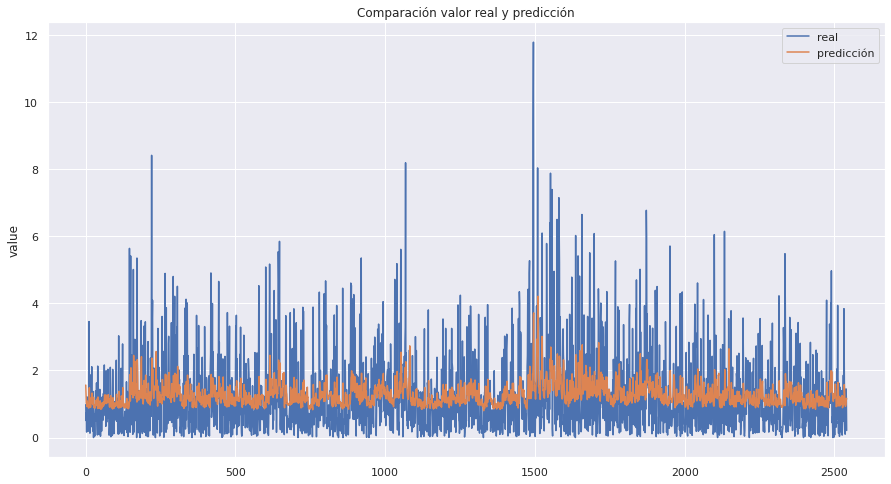

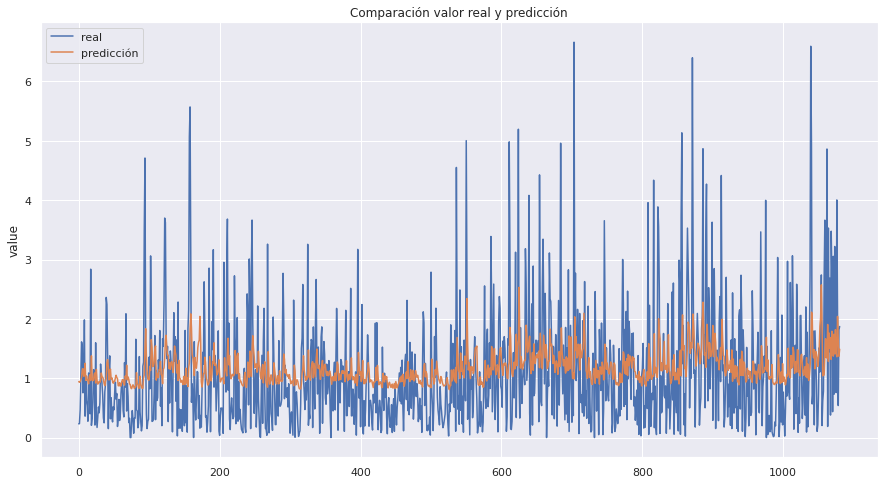

In [56]:
tessst=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=32,attributes=1,epochss=100,batch_sizze=16,lag=15,fecha=df_stats.Fecha)
pd.concat([pd.DataFrame(tessst[0]),pd.DataFrame(tessst[1])])
pd.merge(df_stats,pd.concat([pd.DataFrame(tessst[0]),pd.DataFrame(tessst[1])]),how="left",on="Fecha").to_csv("VolatilidadVariablesNoticiasAntes.csv",index=False)